# Introduction to Causal Inference with Probabilistic Programming Languages

In this notebook, we provide an introduction to causal inference using probabilistic programming languages (PPLs).

## Why Probabilistic Programming Languages?

**Probabilistic Programming Languages (PPLs)** like NumPyro, PyMC, and Stan let us:

1. **Express causal models naturally**: We can model both the treatment assignment mechanism
   and the outcome process, making confounding explicit.

2. **Quantify uncertainty**: Bayesian inference gives us full posterior distributions, not
   just point estimates. We get credible intervals that properly account for uncertainty.

3. **Use the `do` operator**: PPLs let us implement Pearl's do-calculus directly, allowing
   us to compute counterfactuals ("what if everyone received treatment?").

4. **Flexible modeling**: We can use non-linear models, hierarchical structures, and other
   sophisticated approaches while maintaining causal interpretability.

## What You'll Learn

In this notebook, we'll:

- **Build a causal model** that accounts for confounders
- **Estimate the Average Treatment Effect (ATE)** using Bayesian inference
- **Compare naive vs. adjusted estimates** to see the impact of confounding
- **Use the `do` operator** to compute counterfactual outcomes
- **Validate our model** using prior predictive checks, convergence diagnostics, and posterior
  predictive checks

We'll use the famous **Lalonde dataset**, which studies the effect of a job training program
on earnings. This dataset is a classic in causal inference because it demonstrates how naive
comparisons can be misleading when confounders are present.

## How?

We reproduce the approach from [ChiRho's backdoor adjustment tutorial](https://basisresearch.github.io/chirho/backdoor.html)
using NumPyro (and a simpler model).

### Data Source

We use the [Lalonde dataset](https://rugg2.github.io/Lalonde%20dataset%20-%20Causal%20Inference.html),
which is a classic in causal inference because it demonstrates how naive
comparisons can be misleading when confounders are present.

> The study looked at the effectiveness of a job training program (the treatment) on the real earnings of an individual, a couple years after completion of the program.
>
> The data consists of a number of demographic variables (age, race, academic background, and previous real earnings), as well as a treatment indicator, and the real earnings in the year 1978 (the response).
>
> **Reference**: Robert Lalonde, "Evaluating the Econometric Evaluations of Training Programs", American Economic Review, Vol. 76, pp. 604-620

## Prepare Notebook

In [1]:
import arviz as az
import graphviz as gr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from jax.nn import softplus
from jax.scipy.special import expit
from jaxtyping import Array, Float, Int
from numpyro.handlers import condition, do
from numpyro.infer import MCMC, NUTS, Predictive
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Read and Preprocess Data

Here, we load the data and preprocess it to be used in the model in the same way as in the original tutorial.

In [2]:
data_path = "https://raw.githubusercontent.com/rugg2/rugg2.github.io/master/lalonde.csv"
data = pd.read_csv(data_path)


# Convert the data to the right format
data["re75"] = data["re75"] / 1_000
# Add a small constant to avoid log(0) in the model
data["re78"] = data["re78"] / 1_000 + 1e-6
data = data.rename(columns={"educ": "education", "hispan": "hispanic"})

# Define the covariates
covariates_names = [
    "education",
    "age",
    "re75",
    "black",
    "hispanic",
    "married",
    "nodegree",
]

# Extract treatment, covariates and earnings from the dataframe
df = data[["treat", *covariates_names, "re78"]]

n_obs = df.shape[0]

df.head()

treat  education  age  re75  black  hispanic  married  nodegree       re78
0      1         11   37   0.0      1         0        1         1   9.930047
1      1          9   22   0.0      0         1        0         1   3.595895
2      1         12   30   0.0      1         0        0         0  24.909451
3      1         11   27   0.0      1         0        0         1   7.506147
4      1          8   33   0.0      1         0        0         1   0.289791

### Understanding the Data Structure

The following are the main feature groups in the dataset:

- **Treatment variable** (`treat`): The intervention we're studying (job training program)
- **Outcome variable** (`re78`): What we want to measure the effect on (earnings in 1978)
- **Covariates**: Pre-treatment variables that might confound the relationship

## Causal DAG

Before jumping into any modeling, we need a mental model of the causal relationships in the data. From the ChiRho tutorial:

> Specifically, we have written our `causal_model` method below such that covariates influence `training` and `earnings`, and `training` influences `earnings`. To align this model with the specific parametric assumptions used in our case study [LaLonde, 1986], we have chosen to use a logistic function to describe the mechanism for generating training random variables, and a linear Gaussian model for generating earnings.

Hence, we have the following structure:

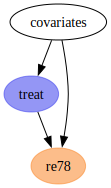

In [3]:
dag = gr.Digraph()

dag.node("treat", color="#2a2eec80", style="filled")
dag.node("re78", color="#fa7c1780", style="filled")
dag.node("covariates")

dag.edge("treat", "re78")
dag.edge("covariates", "treat")
dag.edge("covariates", "re78")

dag

Which concretely looks like this:

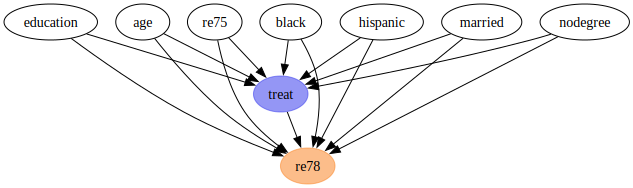

In [4]:
dag = gr.Digraph()

dag.node("treat", color="#2a2eec80", style="filled")
dag.node("re78", color="#fa7c1780", style="filled")

dag.edge("treat", "re78")

for covariate in covariates_names:
    dag.edge(covariate, "treat")
    dag.edge(covariate, "re78")

dag

## Exploratory Data Analysis

/Users/juan.orduz/.local/share/mamba/envs/causal-inference-club-env/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


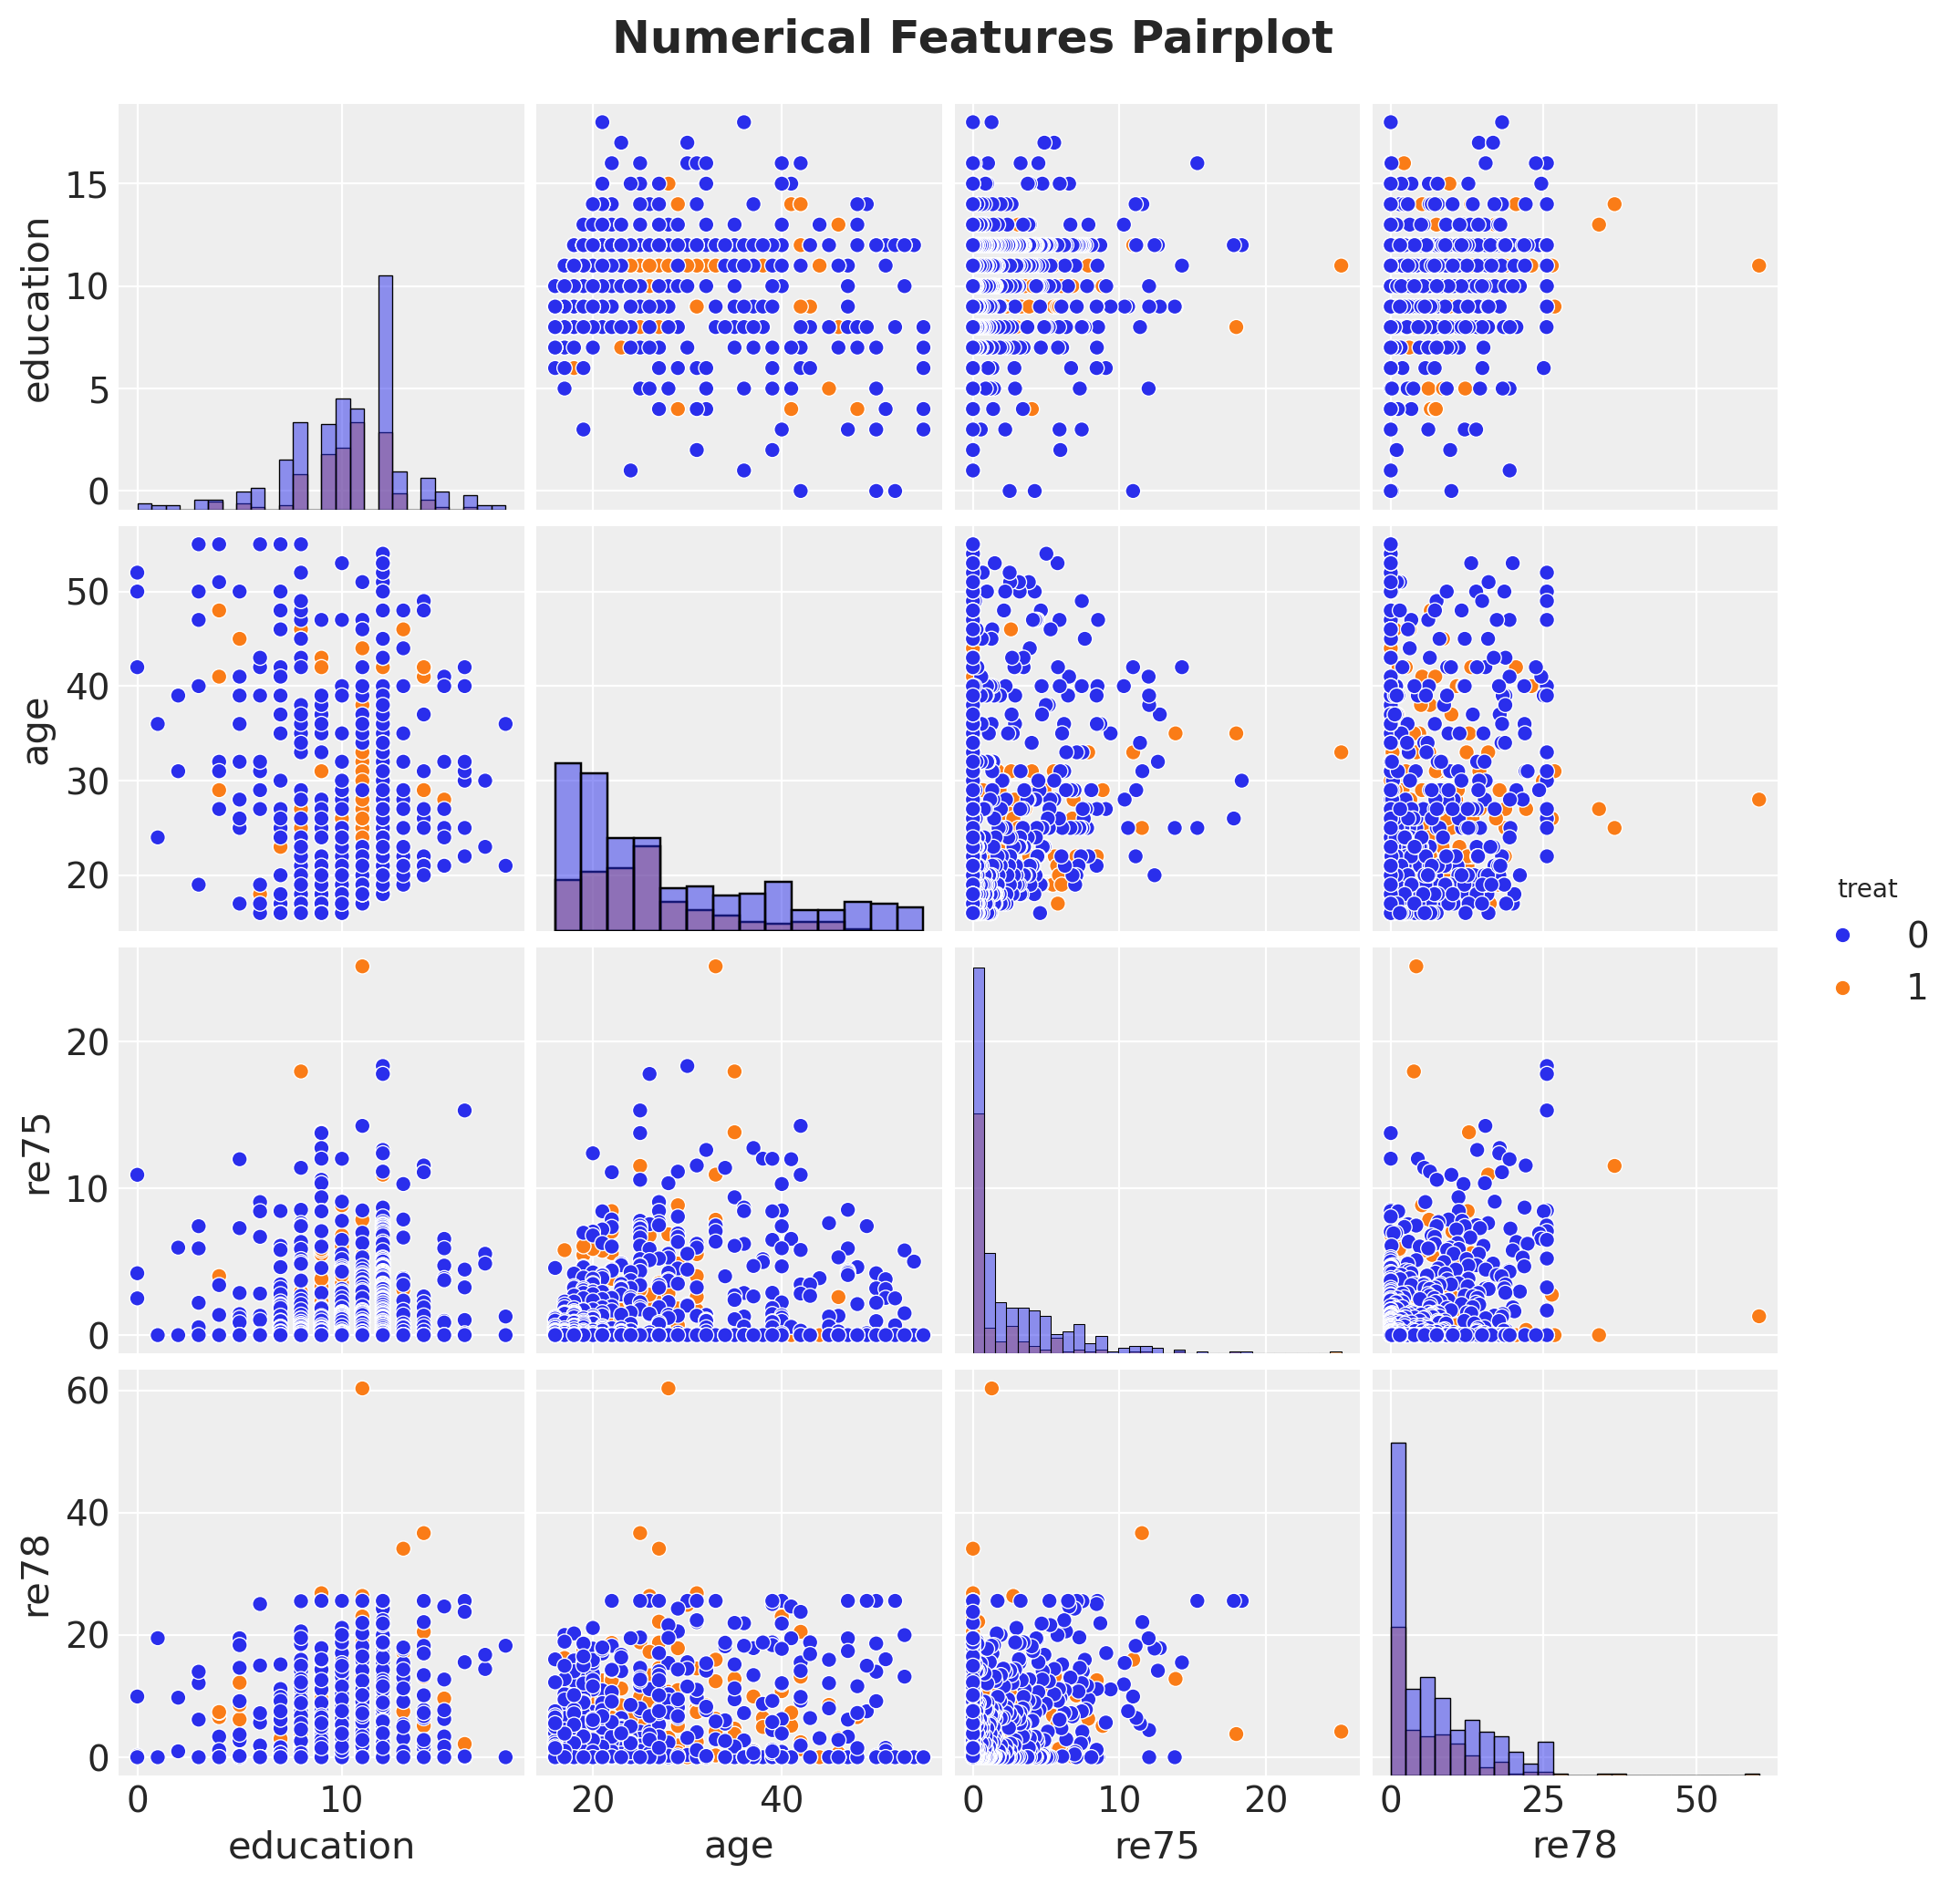

In [5]:
g = sns.pairplot(
    df[["treat", "education", "age", "re75", "re78"]], hue="treat", diag_kind="hist"
)
g.figure.suptitle(
    "Numerical Features Pairplot", fontsize=18, fontweight="bold", y=1.03
);

In [ ]:
# Evaluate what our answer would be if we just naively predicted the average earnings
# of treated and untreated individuals, without accounting for the
# potential confounders.
treated_individuals = df[df["treat"] == 1]
untreated_individuals = df[df["treat"] == 0]

naive_prediction = (
    treated_individuals["re78"].mean() - untreated_individuals["re78"].mean()
)
naive_prediction

np.float64(-0.6350262120374222)

### The Confounding Problem

The naive estimate simply compares average earnings between treated and untreated groups.
However, if these groups differ systematically in pre-treatment characteristics (confounders),
the naive estimate will be biased. For example, if the training program targeted individuals
with lower prior earnings, we'd expect them to have lower earnings regardless of treatment.

This is why we need to adjust for confounders—variables that affect both treatment assignment
and the outcome. Our model will account for these by conditioning on covariates.

In [7]:
df_agg = df.groupby("treat").agg(
    count_education=("education", "count"),
    count_age=("age", "count"),
    count_black=("black", "count"),
    count_hispanic=("hispanic", "count"),
    count_married=("married", "count"),
    count_nodegree=("nodegree", "count"),
    mean_age=("age", "mean"),
    mean_re75=("re75", "mean"),
)

df_agg.style.background_gradient(cmap="viridis", axis=0)

## Scale Numerical Features

In general, it is recommended to scale numerical features to help MCMC sampling converge faster and to think about priors in terms of standard deviations. See [Statistical Rethinking](https://xcelab.net/rm/) by Richard McElreath for more details.

In [8]:
num_features = ["education", "age", "re75"]

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(with_mean=False), num_features),
    ],
    remainder="passthrough",
).set_output(transform="pandas")


df_transformed = preprocessor.fit_transform(df)
df_transformed.columns = [col.split("__")[-1] for col in df_transformed.columns]

In [9]:
# Convert to tensors
covariates_obs = jnp.array(
    df_transformed[covariates_names].to_numpy(), dtype=jnp.float32
)
training_obs = jnp.array(df_transformed["treat"].to_numpy(), dtype=jnp.int32)
earnings_obs = jnp.array(df_transformed["re78"].to_numpy(), dtype=jnp.float32)

## Specify Model

Now we proceed to specify the model in NumPyro (it can be done in PyMC as well).


In [ ]:
def treat_model(
    covariates: Float[Array, "n_obs n_covariates"],
) -> Int[Array, " n_obs"]:
    n_obs, n_covariates = covariates.shape

    intercept_treat = numpyro.sample("intercept_treat", dist.Normal(0, 10))

    with numpyro.plate("covariate", n_covariates):
        beta_covariate_treat = numpyro.sample("beta_covariate_treat", dist.Normal(0, 1))

    logit_p_treat = intercept_treat + covariates @ beta_covariate_treat
    p_treat = expit(logit_p_treat)

    with numpyro.plate("obs", n_obs):
        return numpyro.sample("treat", dist.Bernoulli(p_treat))


def earnings_model(covariates: Float[Array, "n_obs n_covariates"]) -> None:
    n_obs, n_covariates = covariates.shape

    intercept_earnings = numpyro.sample("intercept_earnings", dist.Normal(0, 10))
    beta_treat_earnings = numpyro.sample("beta_treat_earnings", dist.Normal(0, 1))
    sigma_earnings = numpyro.sample("sigma_earnings", dist.HalfNormal(10))

    with numpyro.plate("covariate", n_covariates):
        beta_covariate_earnings = numpyro.sample(
            "beta_covariate_earnings", dist.Normal(0, 1)
        )

    treat = treat_model(covariates)

    mu_earnings = numpyro.deterministic(
        "mu_earnings",
        intercept_earnings
        + beta_treat_earnings * treat
        + covariates @ beta_covariate_earnings,
    )

    with numpyro.plate("obs", n_obs):
        numpyro.sample("earnings", dist.Normal(mu_earnings, sigma_earnings))

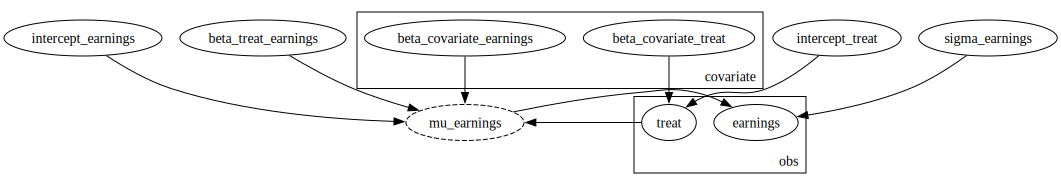

In [11]:
numpyro.render_model(earnings_model, model_kwargs={"covariates": covariates_obs})

## Prior Predictive Checks

In [12]:
prior_predictive = Predictive(earnings_model, num_samples=1_000)

rng_key, rng_subkey = random.split(rng_key)
prior_predictive_samples = prior_predictive(rng_subkey, covariates_obs)

idata = az.from_dict(
    prior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in prior_predictive_samples.items()
    },
    coords={
        "obs_idx": df.index,
        "covariate": covariates_names,
    },
    dims={
        "beta_covariate_treat": ["covariate"],
        "beta_covariate_earnings": ["covariate"],
        "earnings": ["obs_idx"],
        "treat": ["obs_idx"],
        "mu_earnings": ["obs_idx"],
    },
)

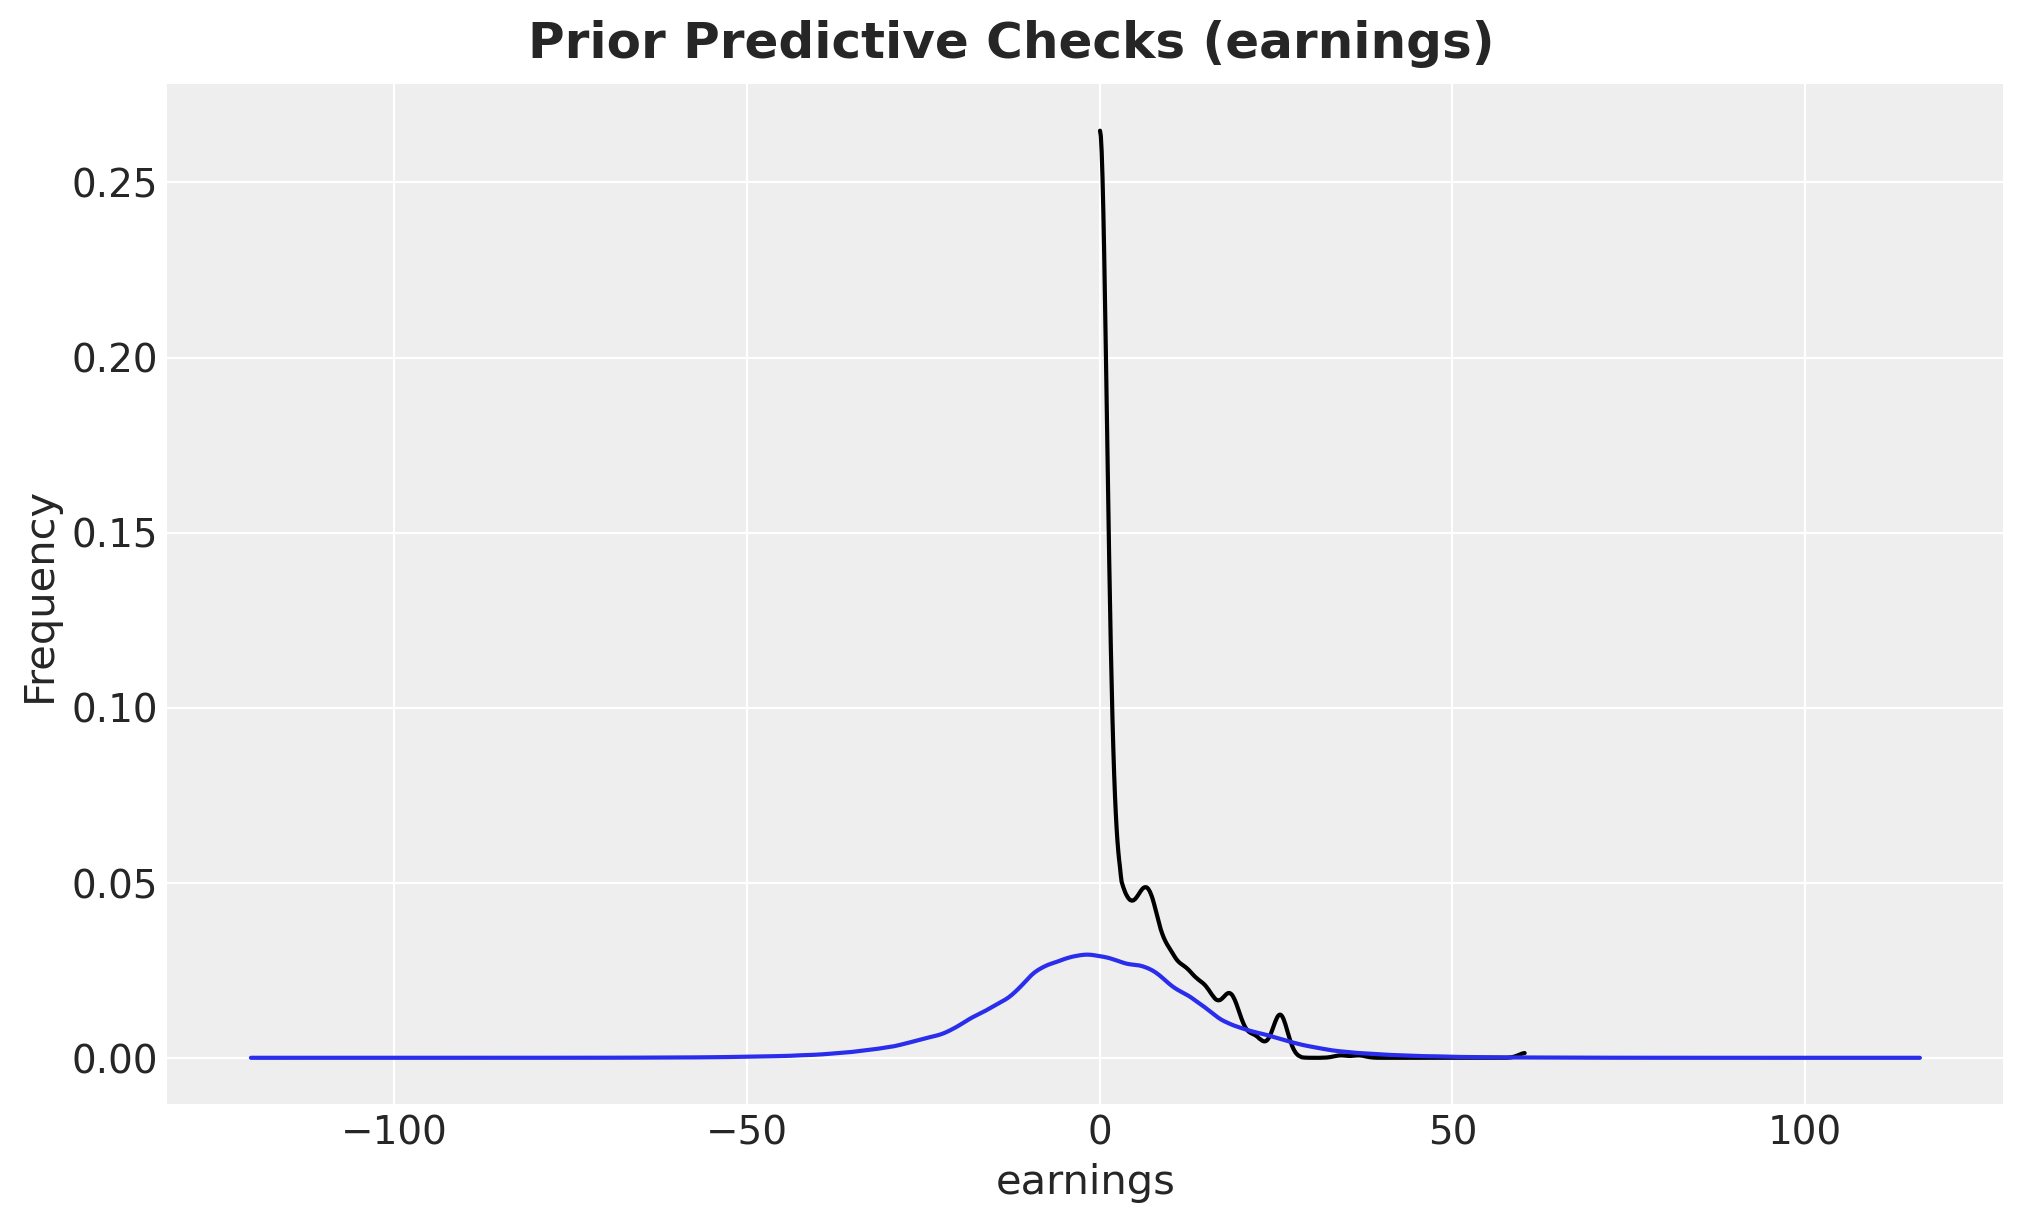

In [13]:
fig, ax = plt.subplots()
az.plot_dist(earnings_obs, color="black", ax=ax)
az.plot_dist(
    idata["prior_predictive"]["earnings"].to_numpy().flatten(), color="C0", ax=ax
)
ax.set(xlabel="earnings", ylabel="Frequency")
fig.suptitle("Prior Predictive Checks (earnings)", fontsize=18, fontweight="bold");

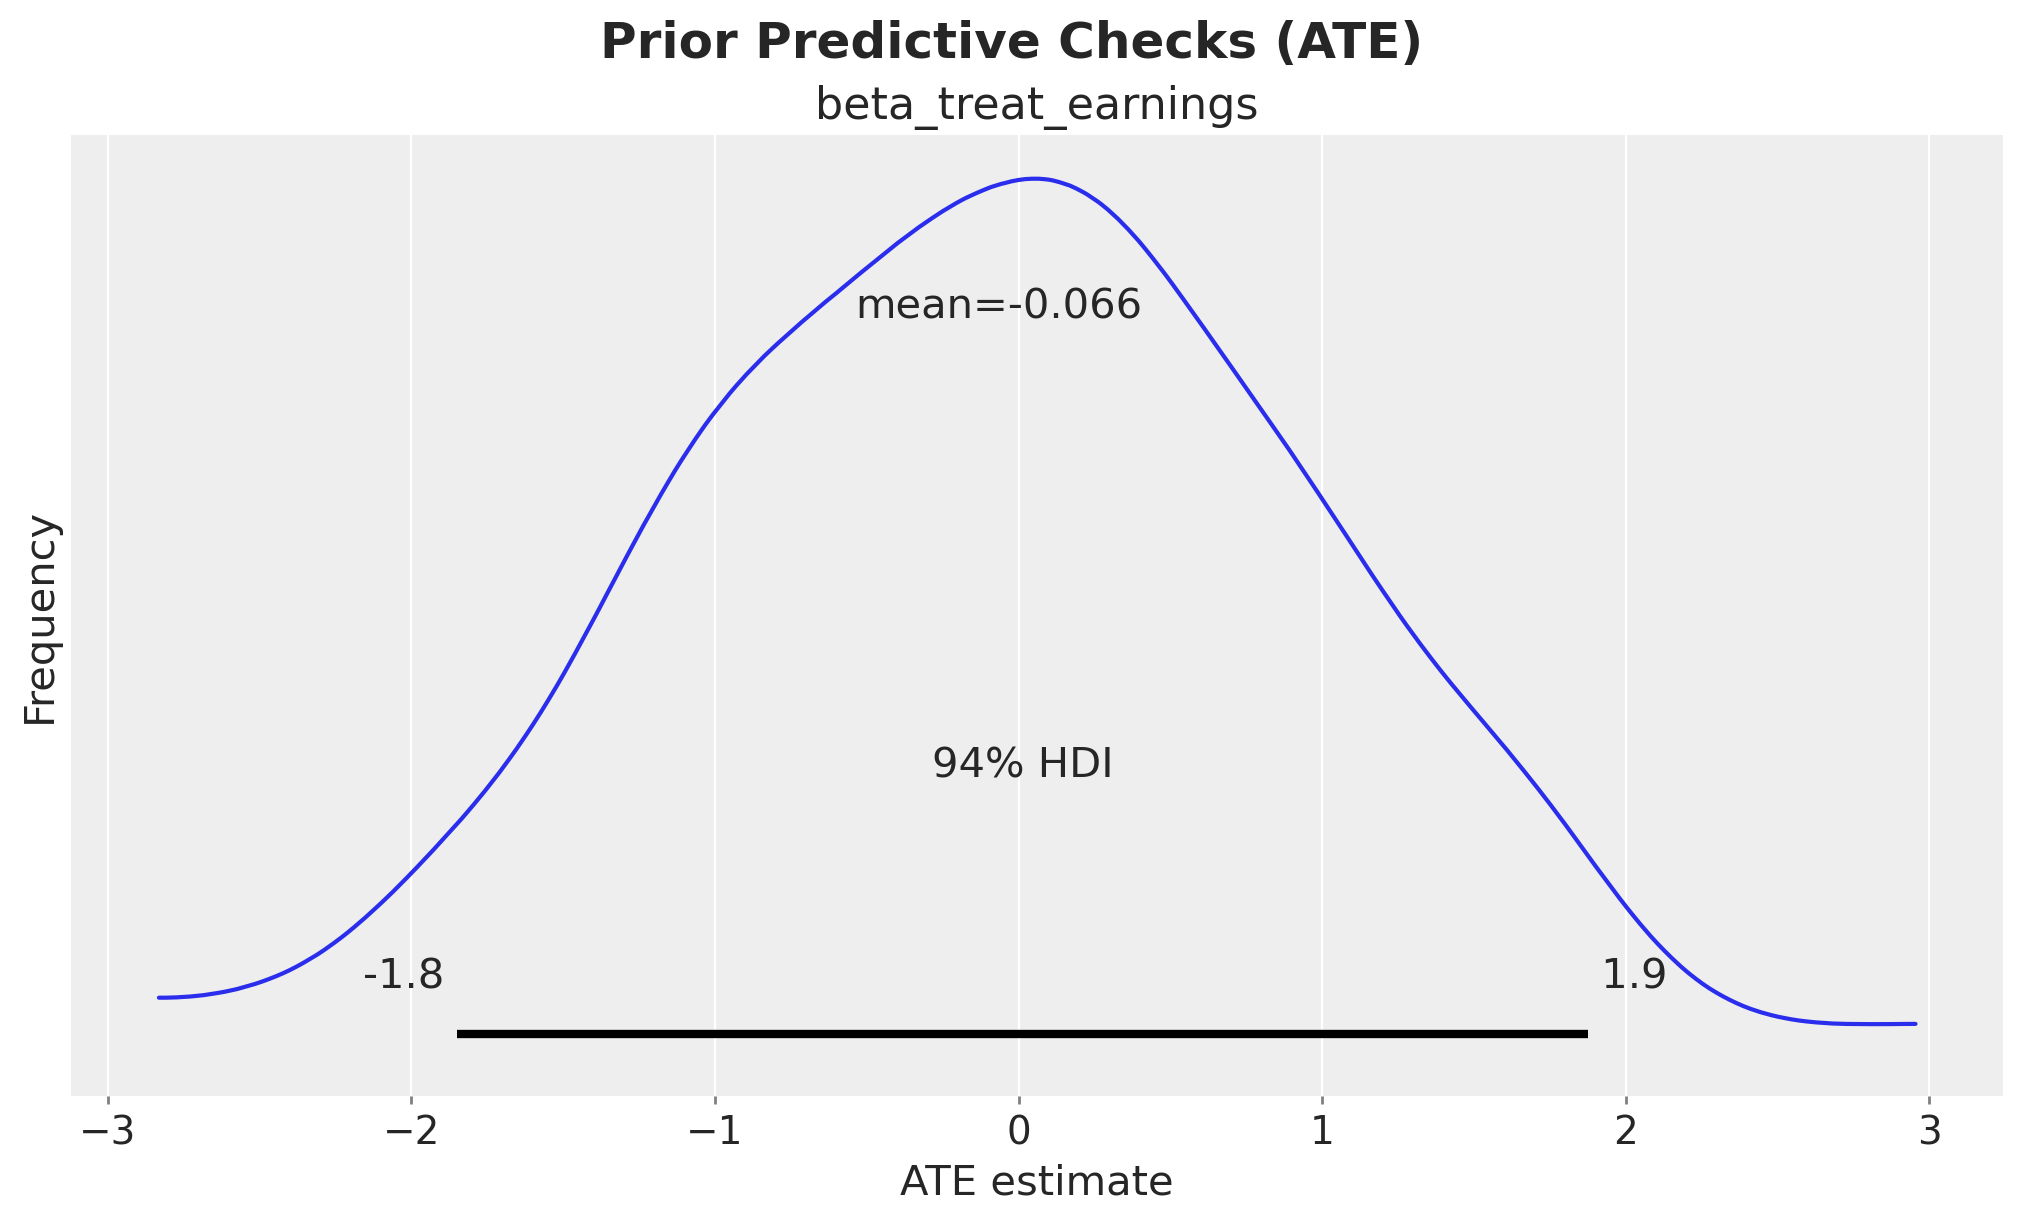

In [14]:
fig, ax = plt.subplots()
az.plot_posterior(idata["prior_predictive"], var_names=["beta_treat_earnings"], ax=ax)
ax.set(xlabel="ATE estimate", ylabel="Frequency")
fig.suptitle("Prior Predictive Checks (ATE)", fontsize=18, fontweight="bold");

## Model Fit

We now condition the model on the observed data and sample from the posterior distribution using MCMC (we could alse use stochastic variational inference or other methods to scale up).

In [15]:
conditioned_earnings_model = condition(
    earnings_model, {"treat": training_obs, "earnings": earnings_obs}
)

Let's take a look at the conditioned model:

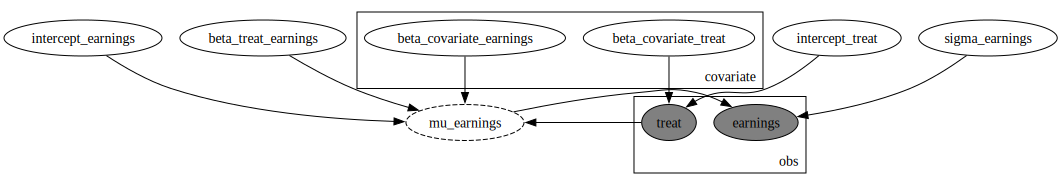

In [16]:
numpyro.render_model(
    conditioned_earnings_model, model_kwargs={"covariates": covariates_obs}
)

We run NUTS to sample from the posterior distribution.

In [17]:
nuts_kernel = NUTS(model=conditioned_earnings_model, target_accept_prob=0.8)
mcmc = MCMC(sampler=nuts_kernel, num_samples=2_000, num_warmup=1_000, num_chains=5)

rng_key, rng_state = random.split(rng_key)
mcmc.run(rng_key, covariates_obs)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

We now extract the posterior samples and store them in an ArviZ InferenceData object.

In [18]:
idata.extend(
    az.from_numpyro(
        mcmc,
        coords={
            "obs_idx": df.index,
            "covariate": covariates_names,
        },
        dims={
            "beta_covariate_treat": ["covariate"],
            "beta_covariate_earnings": ["covariate"],
            "earnings": ["obs_idx"],
            "treat": ["obs_idx"],
            "mu_earnings": ["obs_idx"],
        },
    )
)

## Diagnostics

We need to check the quality of the posterior samples. First, we check the trace of the model to ensure it is mixing well.

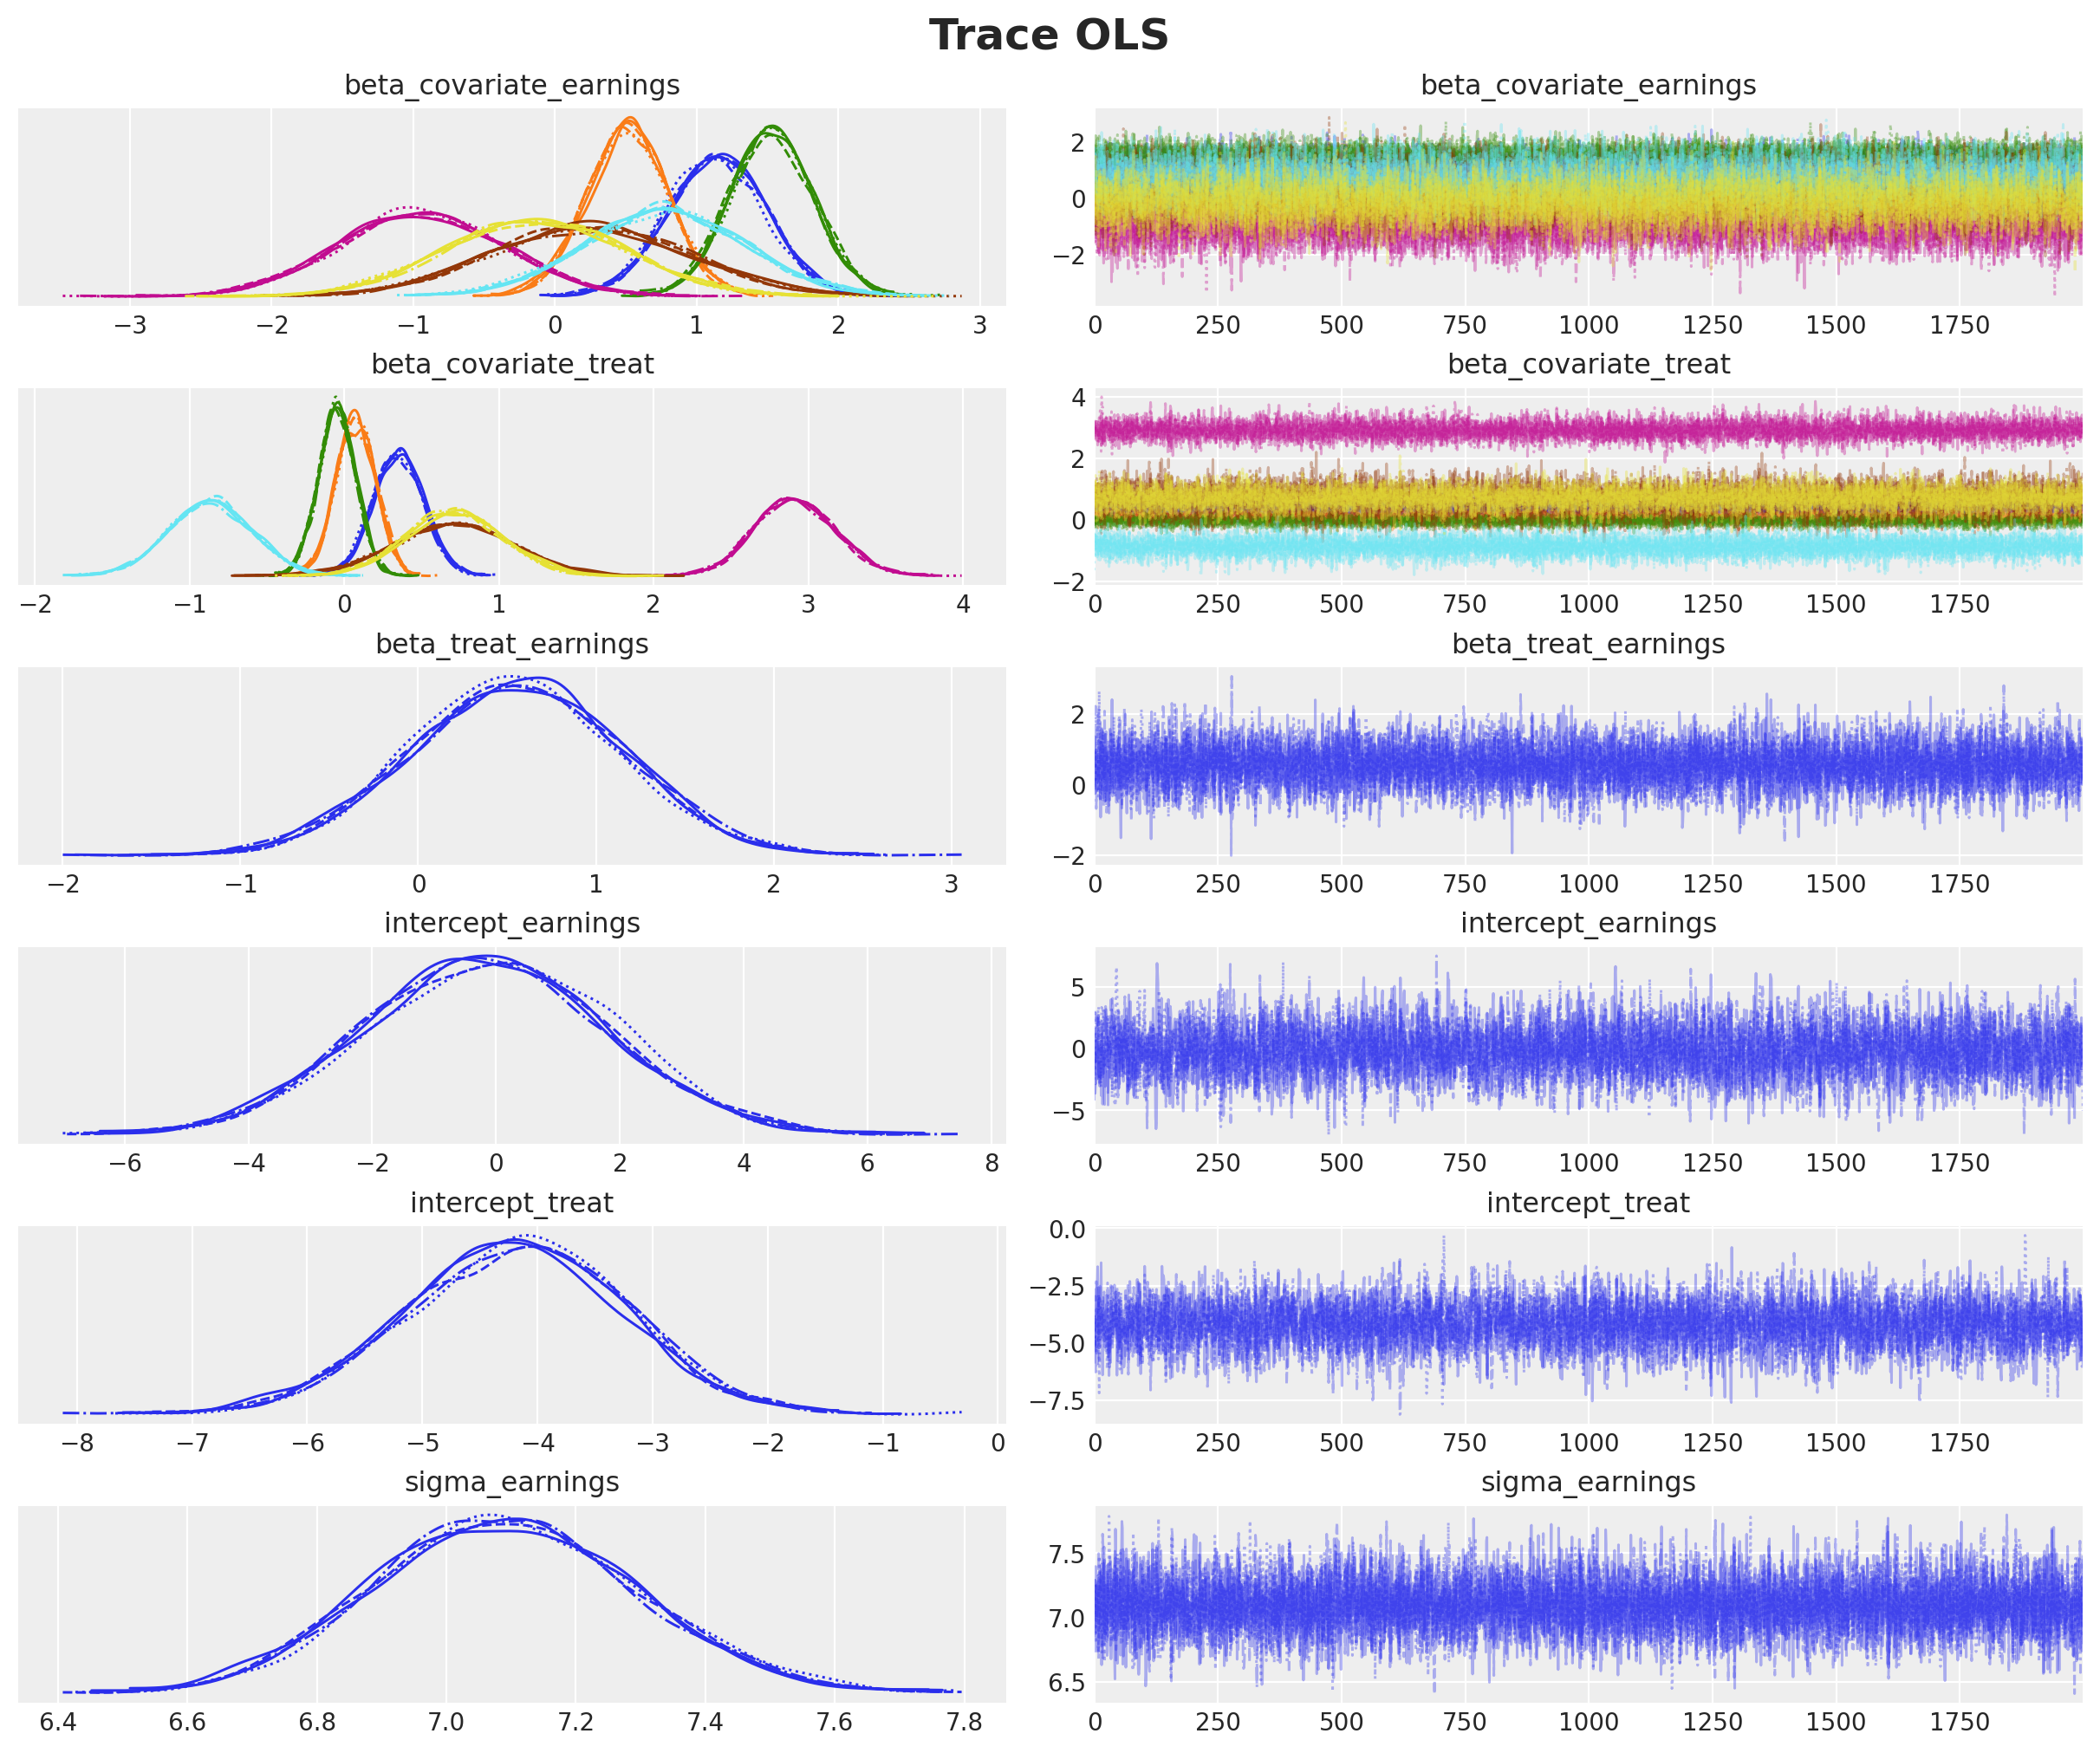

In [19]:
axes = az.plot_trace(
    data=idata,
    var_names=["~mu_earnings"],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Trace OLS", fontsize=18, fontweight="bold");

In [20]:
az.summary(idata, var_names=["~mu_earnings"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
beta_covariate_earnings[education]  1.141  0.344   0.475    1.768      0.004   
beta_covariate_earnings[age]        0.512  0.290  -0.038    1.059      0.003   
beta_covariate_earnings[re75]       1.528  0.292   0.988    2.088      0.003   
beta_covariate_earnings[black]     -0.948  0.583  -2.031    0.144      0.006   
beta_covariate_earnings[hispanic]   0.239  0.693  -1.027    1.549      0.007   
beta_covariate_earnings[married]    0.774  0.568  -0.262    1.903      0.006   
beta_covariate_earnings[nodegree]  -0.142  0.632  -1.369    1.006      0.008   
beta_covariate_treat[education]     0.350  0.163   0.050    0.660      0.002   
beta_covariate_treat[age]           0.074  0.127  -0.168    0.308      0.001   
beta_covariate_treat[re75]         -0.047  0.120  -0.275    0.177      0.001   
beta_covariate_treat[black]         2.913  0.260   2.448    3.414      0.003   
beta_covariate_treat[hispanic]      0.702  0.386  -0.016    1.433      0.004   
beta_covariate_treat[married]      -0.869  0.269  -1.396   -0.382      0.003   
beta_covariate_treat[nodegree]      0.709  0.313   0.121    1.296      0.004   
beta_treat_earnings                 0.552  0.589  -0.579    1.609      0.006   
intercept_earnings                 -0.155  1.960  -3.654    3.658      0.027   
intercept_treat                    -4.192  0.951  -6.034   -2.499      0.013   
sigma_earnings                      7.093  0.204   6.728    7.490      0.002   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
beta_covariate_earnings[education]    0.003    6024.0    6581.0    1.0  
beta_covariate_earnings[age]          0.003    7991.0    6787.0    1.0  
beta_covariate_earnings[re75]         0.003   10393.0    7452.0    1.0  
beta_covariate_earnings[black]        0.006    8936.0    7450.0    1.0  
beta_covariate_earnings[hispanic]     0.007   10692.0    7408.0    1.0  
beta_covariate_earnings[married]      0.005    8821.0    7176.0    1.0  
beta_covariate_earnings[nodegree]     0.006    6921.0    7417.0    1.0  
beta_covariate_treat[education]       0.002    5842.0    7050.0    1.0  
beta_covariate_treat[age]             0.001    8419.0    7312.0    1.0  
beta_covariate_treat[re75]            0.001   10957.0    7220.0    1.0  
beta_covariate_treat[black]           0.003    8423.0    6218.0    1.0  
beta_covariate_treat[hispanic]        0.004    9131.0    7513.0    1.0  
beta_covariate_treat[married]         0.003    9308.0    7386.0    1.0  
beta_covariate_treat[nodegree]        0.003    6431.0    7210.0    1.0  
beta_treat_earnings                   0.006    9559.0    7691.0    1.0  
intercept_earnings                    0.020    5201.0    5885.0    1.0  
intercept_treat                       0.010    5199.0    5921.0    1.0  
sigma_earnings                        0.002   10312.0    6934.0    1.0

**R-hat (Gelman-Rubin statistic)**: Measures agreement between chains. R-hat ≈ 1.0 means
chains have converged to the same distribution. Values > 1.1 suggest the sampler hasn't
converged yet.

**ESS (Effective Sample Size)**: Measures how many independent samples we effectively have.
Low ESS means samples are highly correlated, reducing the information we can extract.
We want ESS > 400 for reliable credible intervals.

## Posterior Predictive Sampling

Now, we extend the InferenceData object with the posterior predictive samples.

In [21]:
posterior_predictive = Predictive(earnings_model, posterior_samples=mcmc.get_samples())

rng_key, rng_subkey = random.split(rng_key)
posterior_predictive_samples = posterior_predictive(rng_subkey, covariates_obs)

idata.extend(
    az.from_dict(
        posterior_predictive={
            k: np.expand_dims(a=np.asarray(v), axis=0)
            for k, v in posterior_predictive_samples.items()
        },
        coords={
            "obs_idx": df.index,
            "covariate": covariates_names,
        },
        dims={
            "beta_covariate_treat": ["covariate"],
            "beta_covariate_earnings": ["covariate"],
            "earnings": ["obs_idx"],
            "treat": ["obs_idx"],
            "mu_earnings": ["obs_idx"],
        },
    )
)

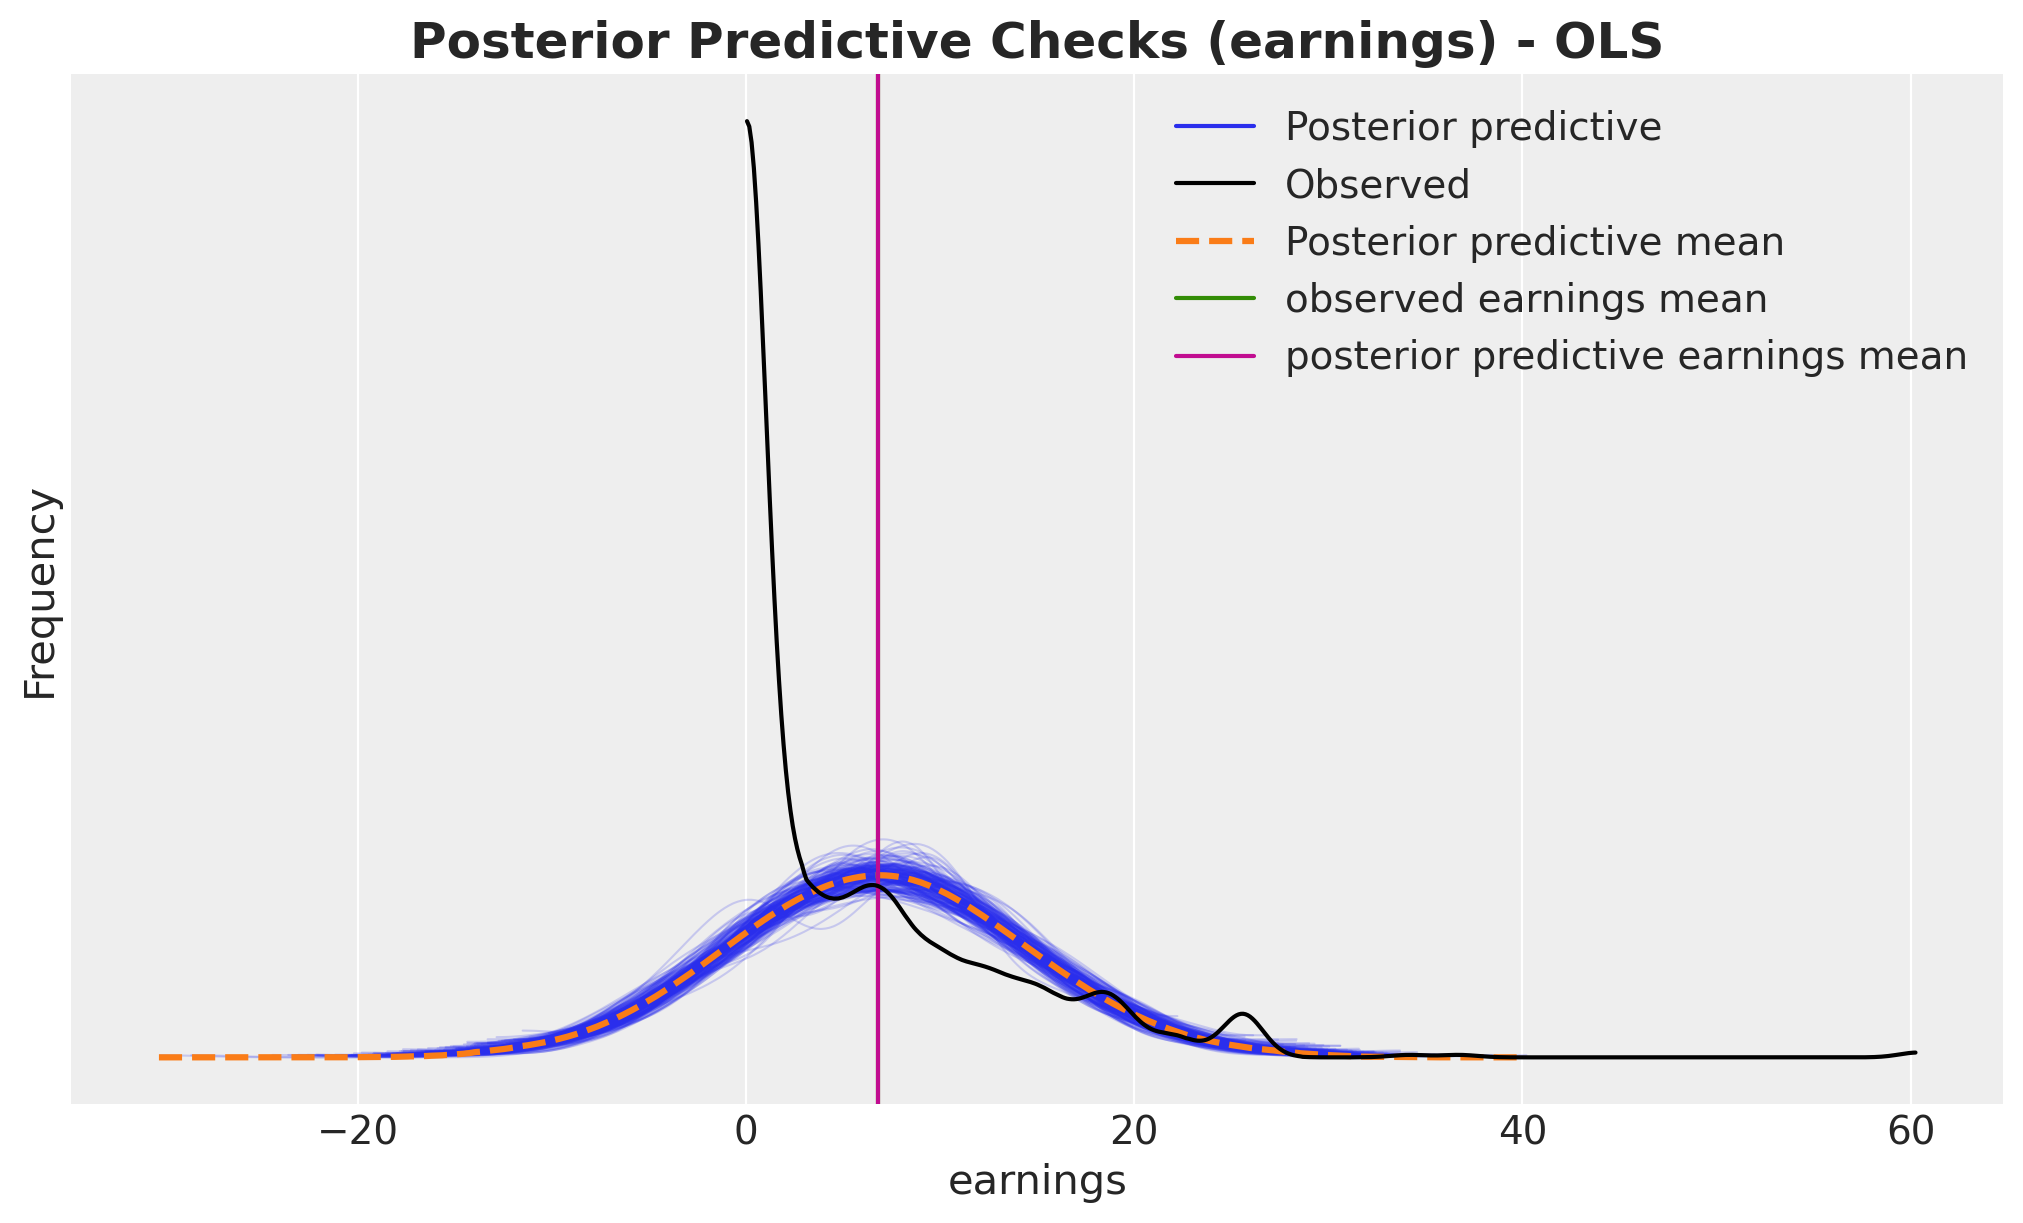

In [22]:
fig, ax = plt.subplots()
az.plot_ppc(idata, var_names=["earnings"], num_pp_samples=200, ax=ax)
ax.axvline(earnings_obs.mean(), color="C2", label="observed earnings mean")
ax.axvline(
    idata["posterior_predictive"]["earnings"].mean().item(),
    color="C3",
    label="posterior predictive earnings mean",
)
ax.legend()
ax.set(xlabel="earnings", ylabel="Frequency")
ax.set_title(
    "Posterior Predictive Checks (earnings) - OLS", fontsize=18, fontweight="bold"
);

## ATE Estimation from Coefficient

In our linear model, `beta_treat_earnings` directly represents the Average Treatment Effect.
This is because we've adjusted for confounders—the coefficient tells us the expected change
in earnings from treatment, holding all covariates constant. This is the causal interpretation
we want.

As in the ChiRho tutorial, we compare the ATE estimation using other methods.

In [23]:
# https://rugg2.github.io/Lalonde%20dataset%20-%20Causal%20Inference.html
blog_prediction_ols = (
    1_548.24 / 1_000
)  # Scaled by 1000 to be consistent with data preprocessing above.
blog_prediction_matching = 1_027.087 / 1_000
blog_prediction_matching_ci95 = [-705.131 / 1_000, 2_759.305 / 1_000]

Let's plot the ATE estimates:

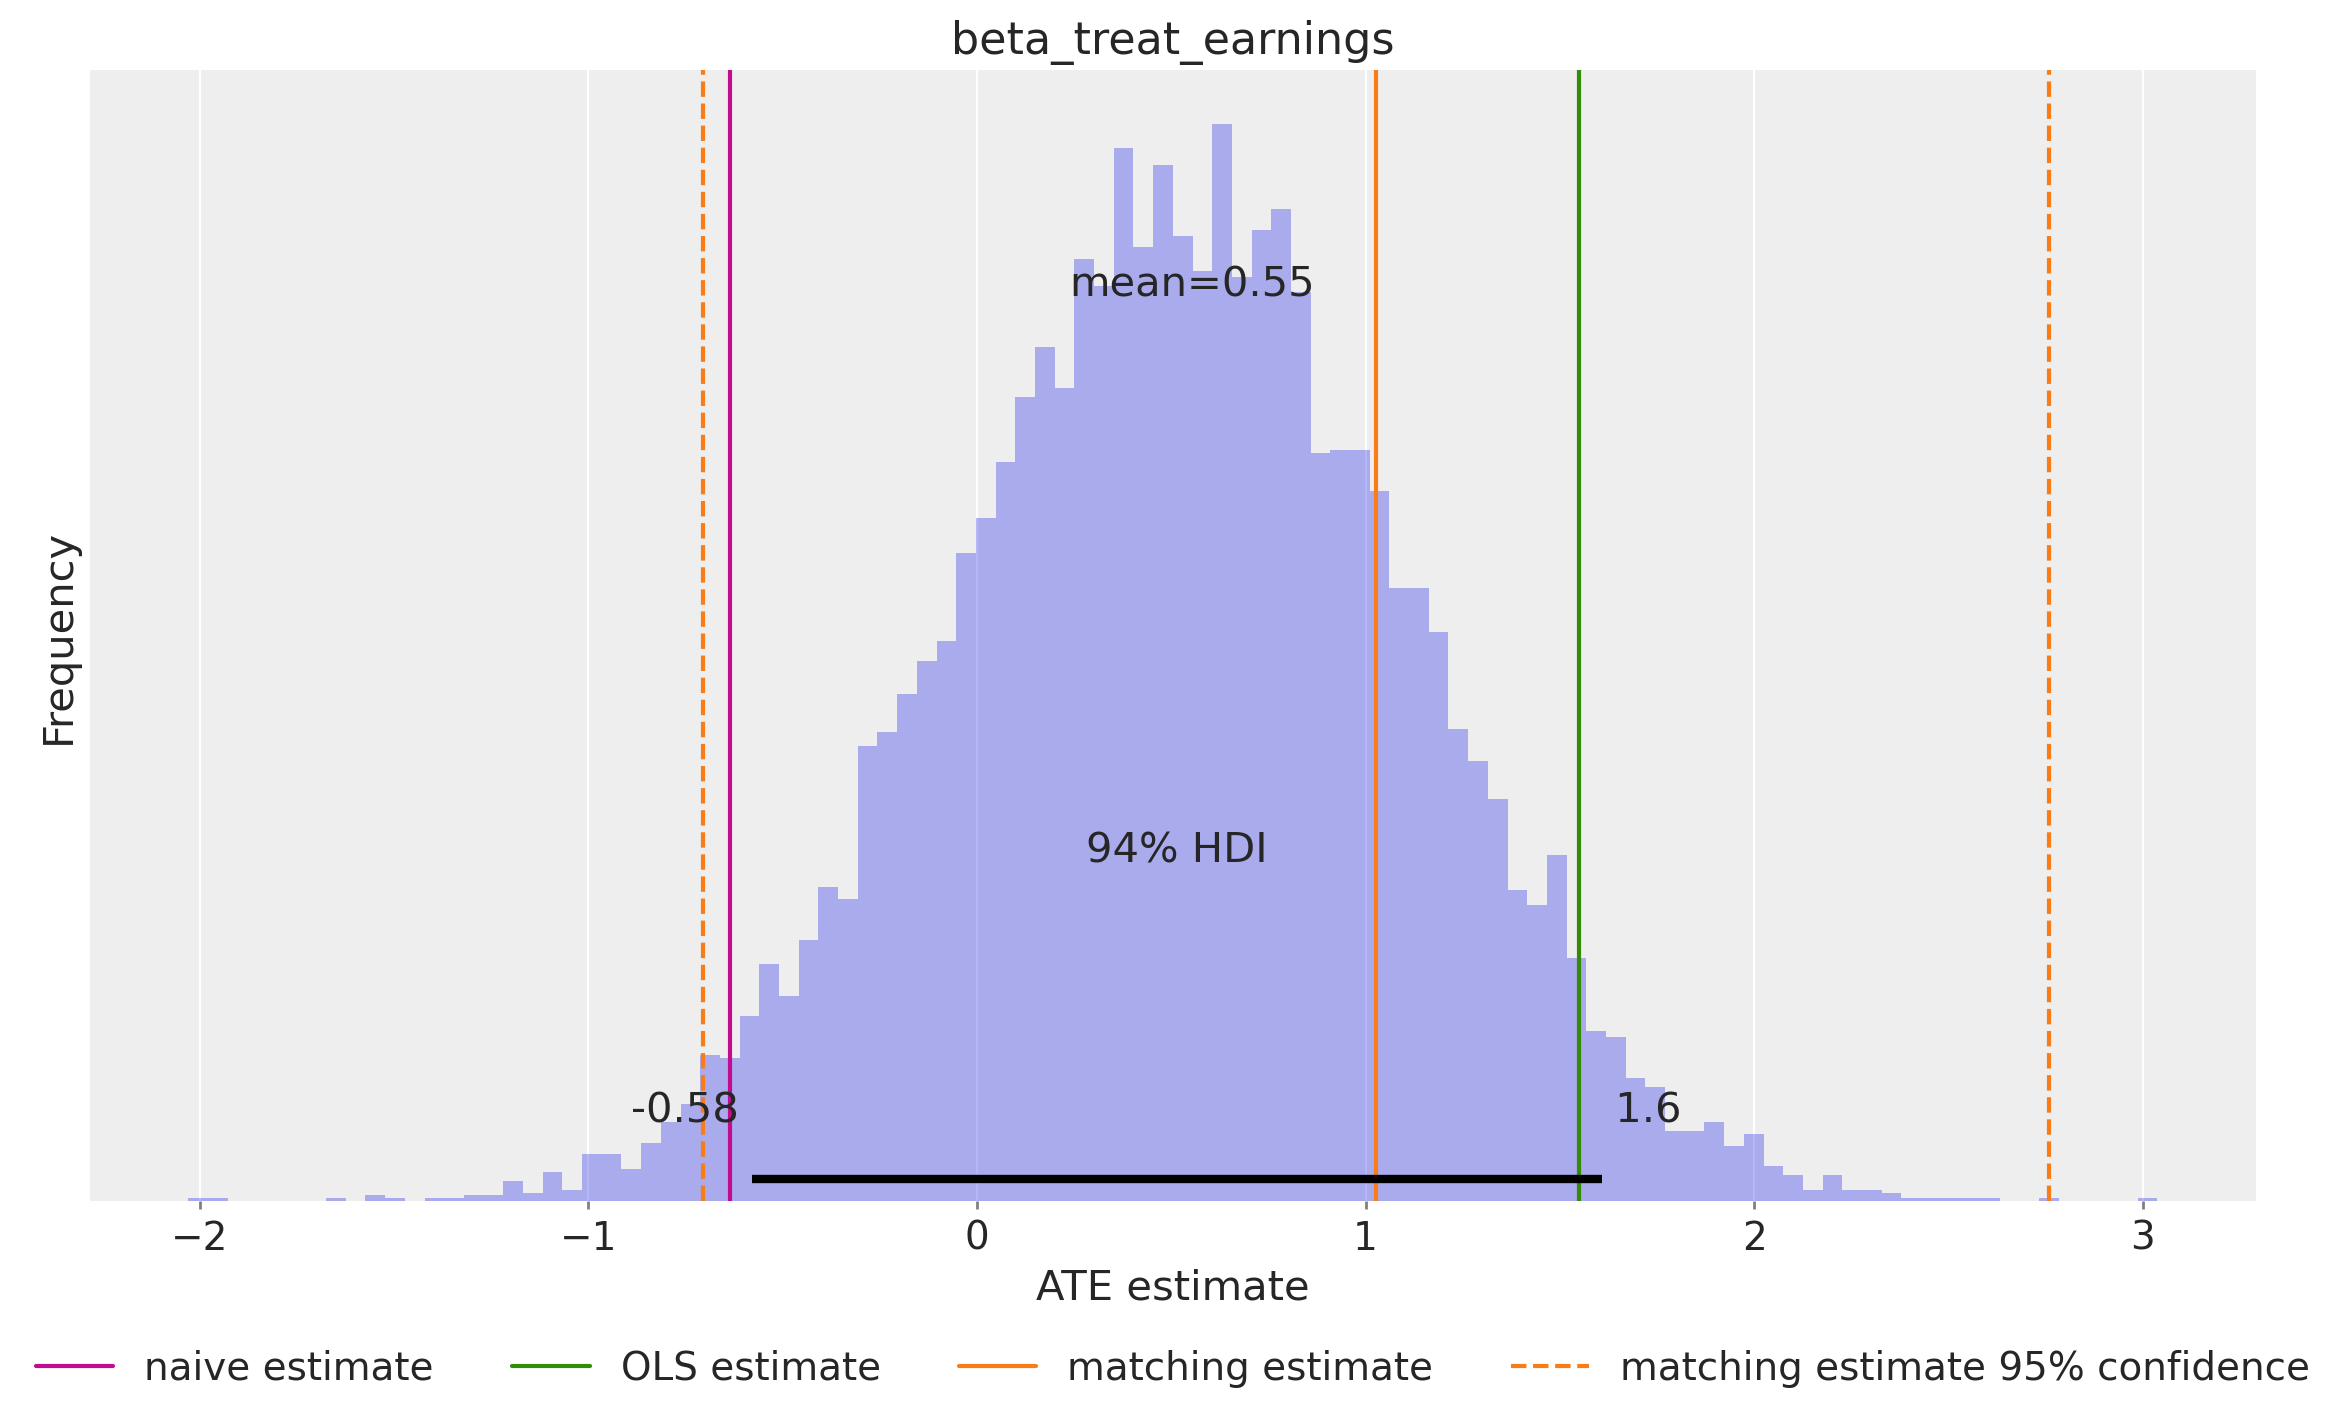

In [24]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.axvline(naive_prediction, color="C3", label="naive estimate")
ax.axvline(blog_prediction_ols, color="C2", label="OLS estimate")
ax.axvline(blog_prediction_matching, color="C1", label="matching estimate")
ax.axvline(
    blog_prediction_matching_ci95[0],
    color="C1",
    linestyle="dashed",
    label="matching estimate 95% confidence",
)
ax.axvline(
    blog_prediction_matching_ci95[1],
    color="C1",
    linestyle="dashed",
)
az.plot_posterior(
    idata["posterior"], var_names=["beta_treat_earnings"], kind="hist", bins=100, ax=ax
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="ATE estimate", ylabel="Frequency");

## ATE Estimation using the `do` Operator

The [`do`](https://num.pyro.ai/en/stable/handlers.html#do) operator represents an intervention: we force treatment to a specific value,
breaking any dependence on confounders. This is the mathematical representation of
"what if everyone received treatment?" vs "what if no one received treatment?"

The difference between these counterfactual outcomes is the ATE. This approach is more
general than coefficient interpretation—it works even with non-linear models. In our
linear case, it should match the coefficient-based estimate.

Let's apply the `do` operator to our model.

In [25]:
do_0_earnings_model = do(
    earnings_model, {"treat": jnp.zeros(shape=(n_obs,), dtype=jnp.int32)}
)
do_1_earnings_model = do(
    earnings_model, {"treat": jnp.ones(shape=(n_obs,), dtype=jnp.int32)}
)

We now generate the posterior predictive samples for the two models using the posterior samples from the MCMC fit.

In [26]:
do_0_posterior_predictive = Predictive(
    do_0_earnings_model, posterior_samples=mcmc.get_samples()
)
rng_key, rng_subkey = random.split(rng_key)
do_0_posterior_predictive_samples = do_0_posterior_predictive(
    rng_subkey, covariates_obs
)


do_1_posterior_predictive = Predictive(
    do_1_earnings_model, posterior_samples=mcmc.get_samples()
)
rng_key, rng_subkey = random.split(rng_key)
do_1_posterior_predictive_samples = do_1_posterior_predictive(
    rng_subkey, covariates_obs
)

We store the posterior predictive samples in an ArviZ InferenceData object.

In [27]:
do_0_idata = az.from_dict(
    posterior_predictive={
        # Add chain dimension for ArviZ compatibility
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in do_0_posterior_predictive_samples.items()
    },
    coords={
        "obs_idx": df.index,
        "covariate": covariates_names,
    },
    dims={
        "beta_covariate_treat": ["covariate"],
        "beta_covariate_earnings": ["covariate"],
        "earnings": ["obs_idx"],
        "treat": ["obs_idx"],
        "mu_earnings": ["obs_idx"],
    },
)

do_1_idata = az.from_dict(
    posterior_predictive={
        # Add chain dimension for ArviZ compatibility
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in do_1_posterior_predictive_samples.items()
    },
    coords={
        "obs_idx": df.index,
        "covariate": covariates_names,
    },
    dims={
        "beta_covariate_treat": ["covariate"],
        "beta_covariate_earnings": ["covariate"],
        "earnings": ["obs_idx"],
        "treat": ["obs_idx"],
        "mu_earnings": ["obs_idx"],
    },
)

We can now compute the ATE using the `do` operator.

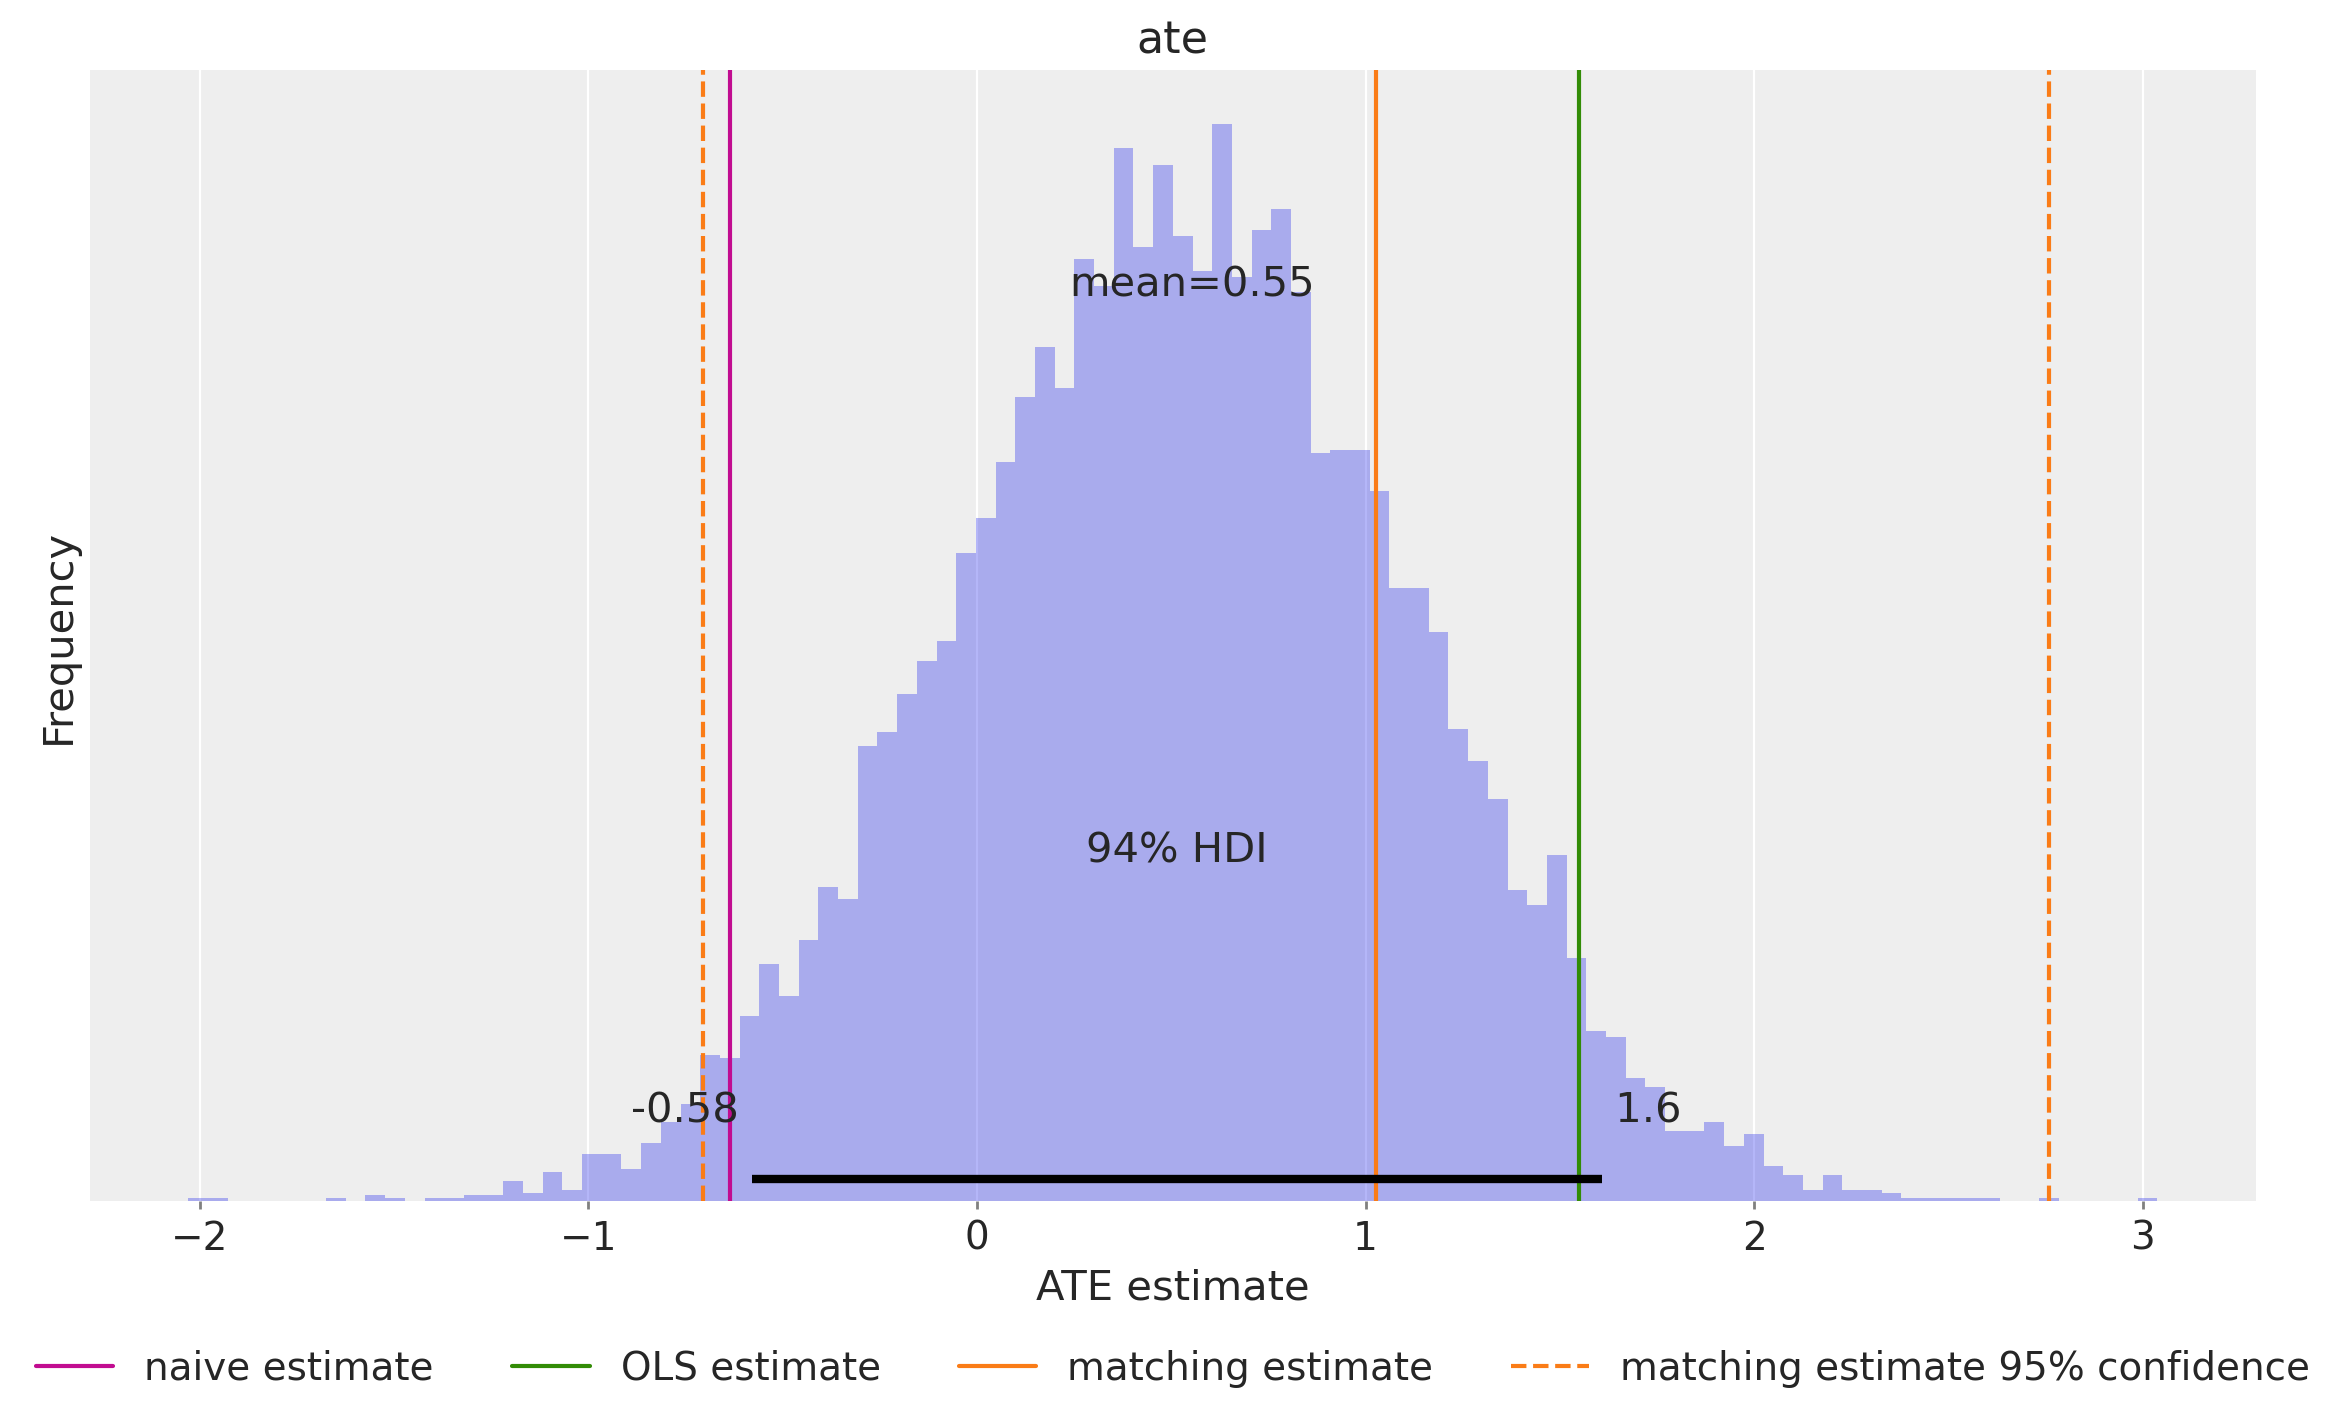

In [28]:
expected_do_1 = do_1_idata["posterior_predictive"]["mu_earnings"]

expected_do_0 = do_0_idata["posterior_predictive"]["mu_earnings"]

ate = (expected_do_1 - expected_do_0).mean(dim="obs_idx").rename("ate")

fig, ax = plt.subplots(figsize=(12, 7))
ax.axvline(naive_prediction, color="C3", label="naive estimate")
ax.axvline(blog_prediction_ols, color="C2", label="OLS estimate")
ax.axvline(blog_prediction_matching, color="C1", label="matching estimate")
ax.axvline(
    blog_prediction_matching_ci95[0],
    color="C1",
    linestyle="dashed",
    label="matching estimate 95% confidence",
)
ax.axvline(
    blog_prediction_matching_ci95[1],
    color="C1",
    linestyle="dashed",
)
az.plot_posterior(ate, kind="hist", bins=100, ax=ax)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="ATE estimate", ylabel="Frequency");

## ATE Estimation Comparison

We compare the ATE estimation using the coefficient method and the `do` operator.


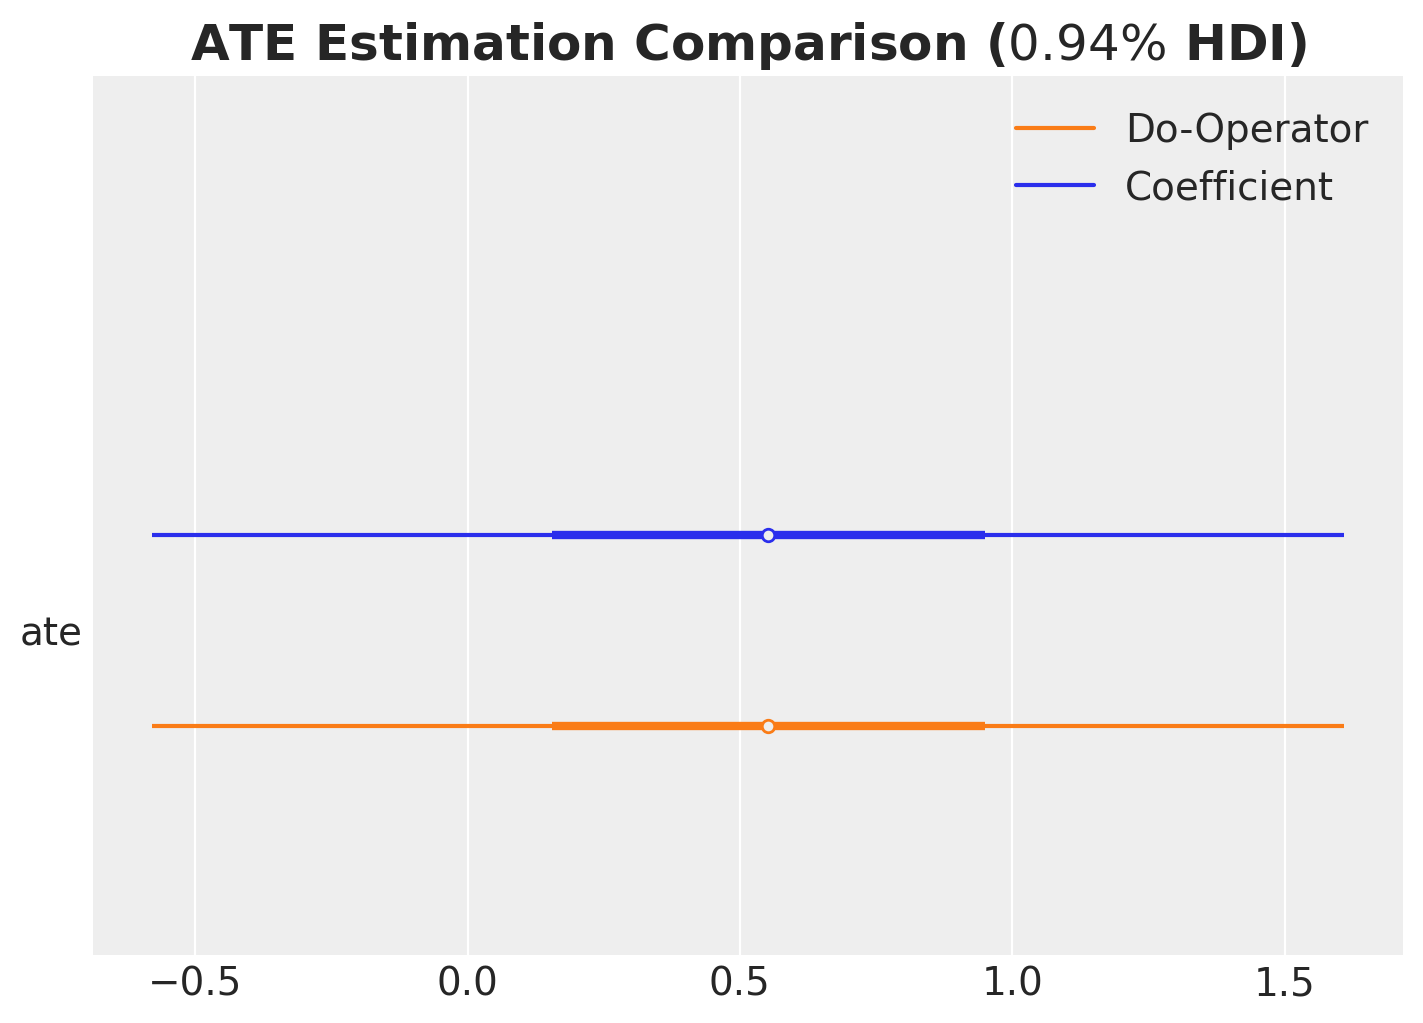

In [29]:
ax, *_ = az.plot_forest(
    data=[idata["posterior"].rename({"beta_treat_earnings": "ate"})["ate"], ate],
    model_names=["Coefficient", "Do-Operator"],
    var_names=["ate"],
    combined=True,
    hdi_prob=0.94,
    figsize=(7, 5),
)
ax.set_title(
    r"ATE Estimation Comparison ($0.94\%$ HDI)", fontsize=18, fontweight="bold"
);

We can see that the two methods agree.

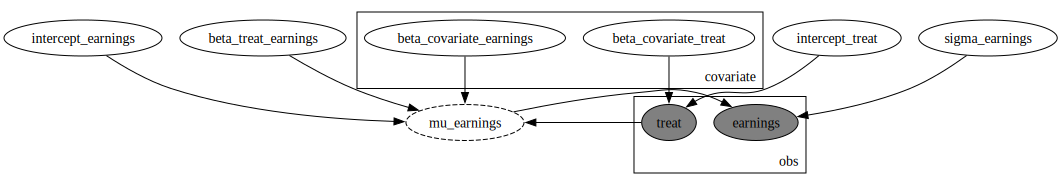

In [30]:
def glm_earnings_model(covariates: Float[Array, "n_obs n_covariates"]) -> None:
    n_obs, n_covariates = covariates.shape

    intercept_earnings = numpyro.sample("intercept_earnings", dist.Normal(0, 10))
    beta_treat_earnings = numpyro.sample("beta_treat_earnings", dist.Normal(0, 1))
    sigma_earnings = numpyro.sample("sigma_earnings", dist.HalfNormal(10))

    with numpyro.plate("covariate", n_covariates):
        beta_covariate_earnings = numpyro.sample(
            "beta_covariate_earnings", dist.Normal(0, 1)
        )

    treat = treat_model(covariates)

    raw_mu_earnings = (
        intercept_earnings
        + beta_treat_earnings * treat
        + covariates @ beta_covariate_earnings
    )

    mu_earnings = numpyro.deterministic(
        "mu_earnings",
        softplus(raw_mu_earnings),
    )

    concentration = (mu_earnings / sigma_earnings) ** 2
    rate = mu_earnings / sigma_earnings**2

    with numpyro.plate("obs", n_obs):
        numpyro.sample("earnings", dist.Gamma(concentration=concentration, rate=rate))


conditioned_glm_earnings_model = condition(
    glm_earnings_model, {"treat": training_obs, "earnings": earnings_obs}
)

numpyro.render_model(
    conditioned_glm_earnings_model, model_kwargs={"covariates": covariates_obs}
)

In [31]:
glm_nuts_kernel = NUTS(model=conditioned_glm_earnings_model, target_accept_prob=0.8)
glm_mcmc = MCMC(
    sampler=glm_nuts_kernel, num_samples=2_000, num_warmup=1_000, num_chains=5
)

rng_key, rng_subkey = random.split(rng_key)
glm_mcmc.run(rng_subkey, covariates_obs)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

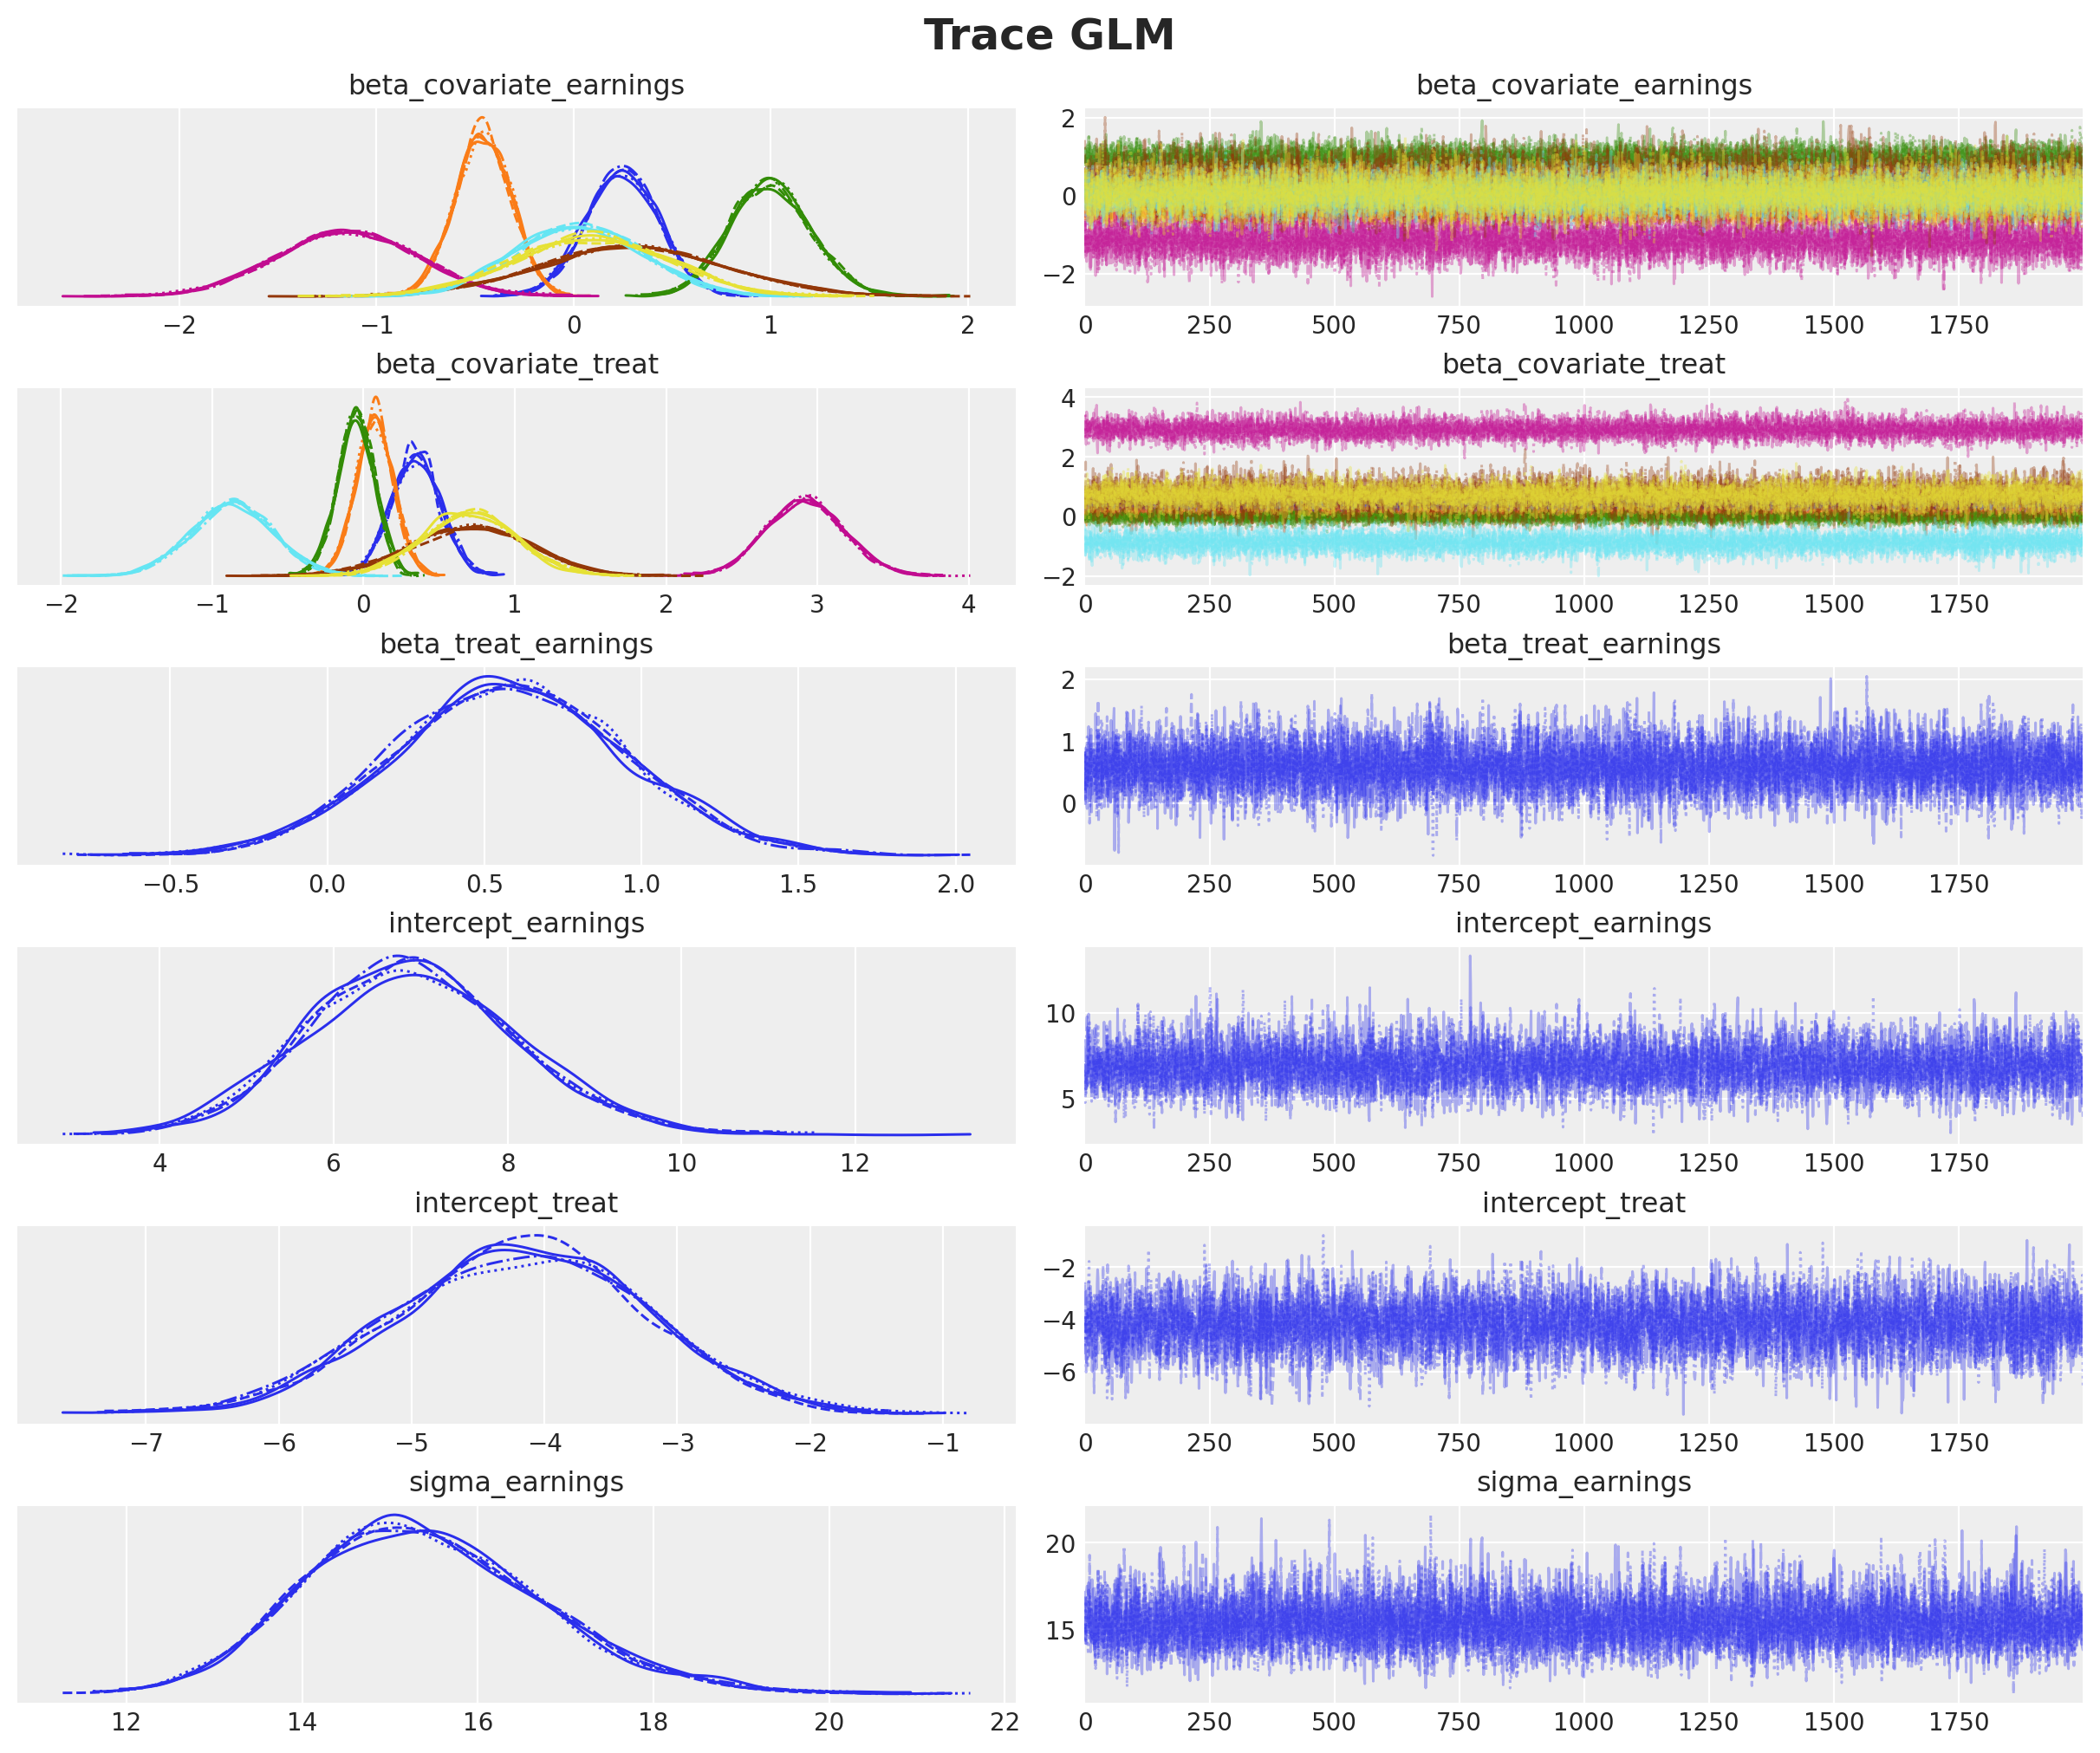

In [32]:
glm_idata = az.from_numpyro(
    glm_mcmc,
    coords={
        "obs_idx": df.index,
        "covariate": covariates_names,
    },
    dims={
        "beta_covariate_treat": ["covariate"],
        "beta_covariate_earnings": ["covariate"],
        "earnings": ["obs_idx"],
        "treat": ["obs_idx"],
        "mu_earnings": ["obs_idx"],
    },
)

axes = az.plot_trace(
    data=glm_idata,
    var_names=["~mu_earnings"],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Trace GLM", fontsize=18, fontweight="bold");

In [33]:
glm_posterior_predictive = Predictive(
    glm_earnings_model, posterior_samples=glm_mcmc.get_samples()
)

rng_key, rng_subkey = random.split(rng_key)
glm_posterior_predictive_samples = glm_posterior_predictive(rng_subkey, covariates_obs)

glm_idata.extend(
    az.from_dict(
        posterior_predictive={
            k: np.expand_dims(a=np.asarray(v), axis=0)
            for k, v in glm_posterior_predictive_samples.items()
        },
        coords={
            "obs_idx": df.index,
            "covariate": covariates_names,
        },
        dims={
            "beta_covariate_treat": ["covariate"],
            "beta_covariate_earnings": ["covariate"],
            "earnings": ["obs_idx"],
            "treat": ["obs_idx"],
            "mu_earnings": ["obs_idx"],
        },
    )
)

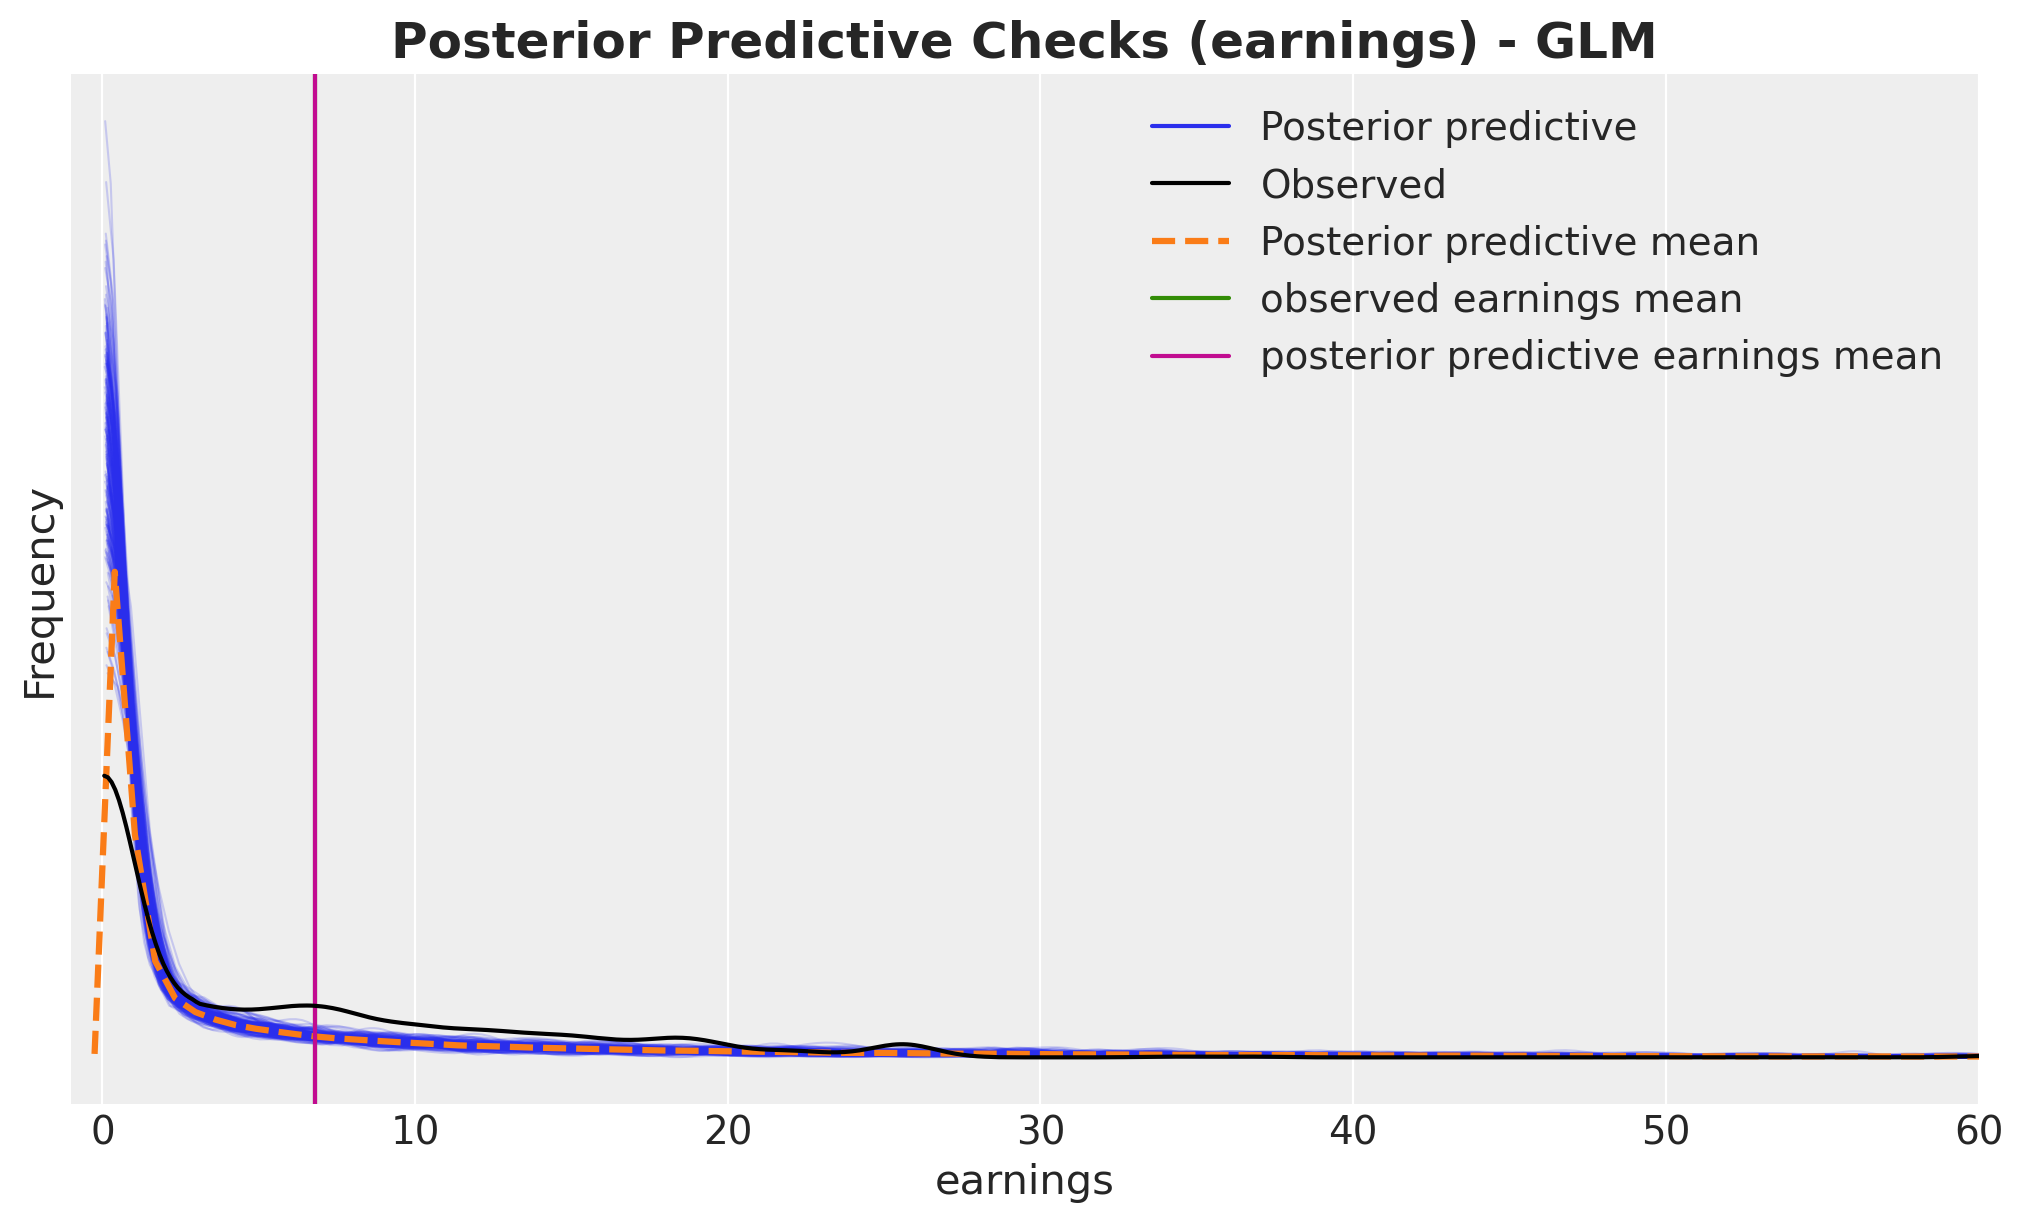

In [34]:
fig, ax = plt.subplots()
az.plot_ppc(glm_idata, var_names=["earnings"], num_pp_samples=200, ax=ax)
ax.axvline(earnings_obs.mean(), color="C2", label="observed earnings mean")
ax.axvline(
    idata["posterior_predictive"]["earnings"].mean().item(),
    color="C3",
    label="posterior predictive earnings mean",
)
ax.legend()
ax.set(xlabel="earnings", ylabel="Frequency", xlim=(-1, 60))
ax.set_title(
    "Posterior Predictive Checks (earnings) - GLM", fontsize=18, fontweight="bold"
);

In [35]:
glm_do_0_earnings_model = do(
    glm_earnings_model, {"treat": jnp.zeros(shape=(n_obs,), dtype=jnp.int32)}
)
glm_do_1_earnings_model = do(
    glm_earnings_model, {"treat": jnp.ones(shape=(n_obs,), dtype=jnp.int32)}
)

glm_do_0_posterior_predictive = Predictive(
    glm_do_0_earnings_model, posterior_samples=glm_mcmc.get_samples()
)
rng_key, rng_subkey = random.split(rng_key)
glm_do_0_posterior_predictive_samples = glm_do_0_posterior_predictive(
    rng_subkey, covariates_obs
)


glm_do_1_posterior_predictive = Predictive(
    glm_do_1_earnings_model, posterior_samples=glm_mcmc.get_samples()
)
rng_key, rng_subkey = random.split(rng_key)
glm_do_1_posterior_predictive_samples = glm_do_1_posterior_predictive(
    rng_subkey, covariates_obs
)

glm_do_0_idata = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in glm_do_0_posterior_predictive_samples.items()
    },
    coords={
        "obs_idx": df.index,
        "covariate": covariates_names,
    },
    dims={
        "beta_covariate_treat": ["covariate"],
        "beta_covariate_earnings": ["covariate"],
        "earnings": ["obs_idx"],
        "treat": ["obs_idx"],
        "mu_earnings": ["obs_idx"],
    },
)

glm_do_1_idata = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in glm_do_1_posterior_predictive_samples.items()
    },
    coords={
        "obs_idx": df.index,
        "covariate": covariates_names,
    },
    dims={
        "beta_covariate_treat": ["covariate"],
        "beta_covariate_earnings": ["covariate"],
        "earnings": ["obs_idx"],
        "treat": ["obs_idx"],
        "mu_earnings": ["obs_idx"],
    },
)

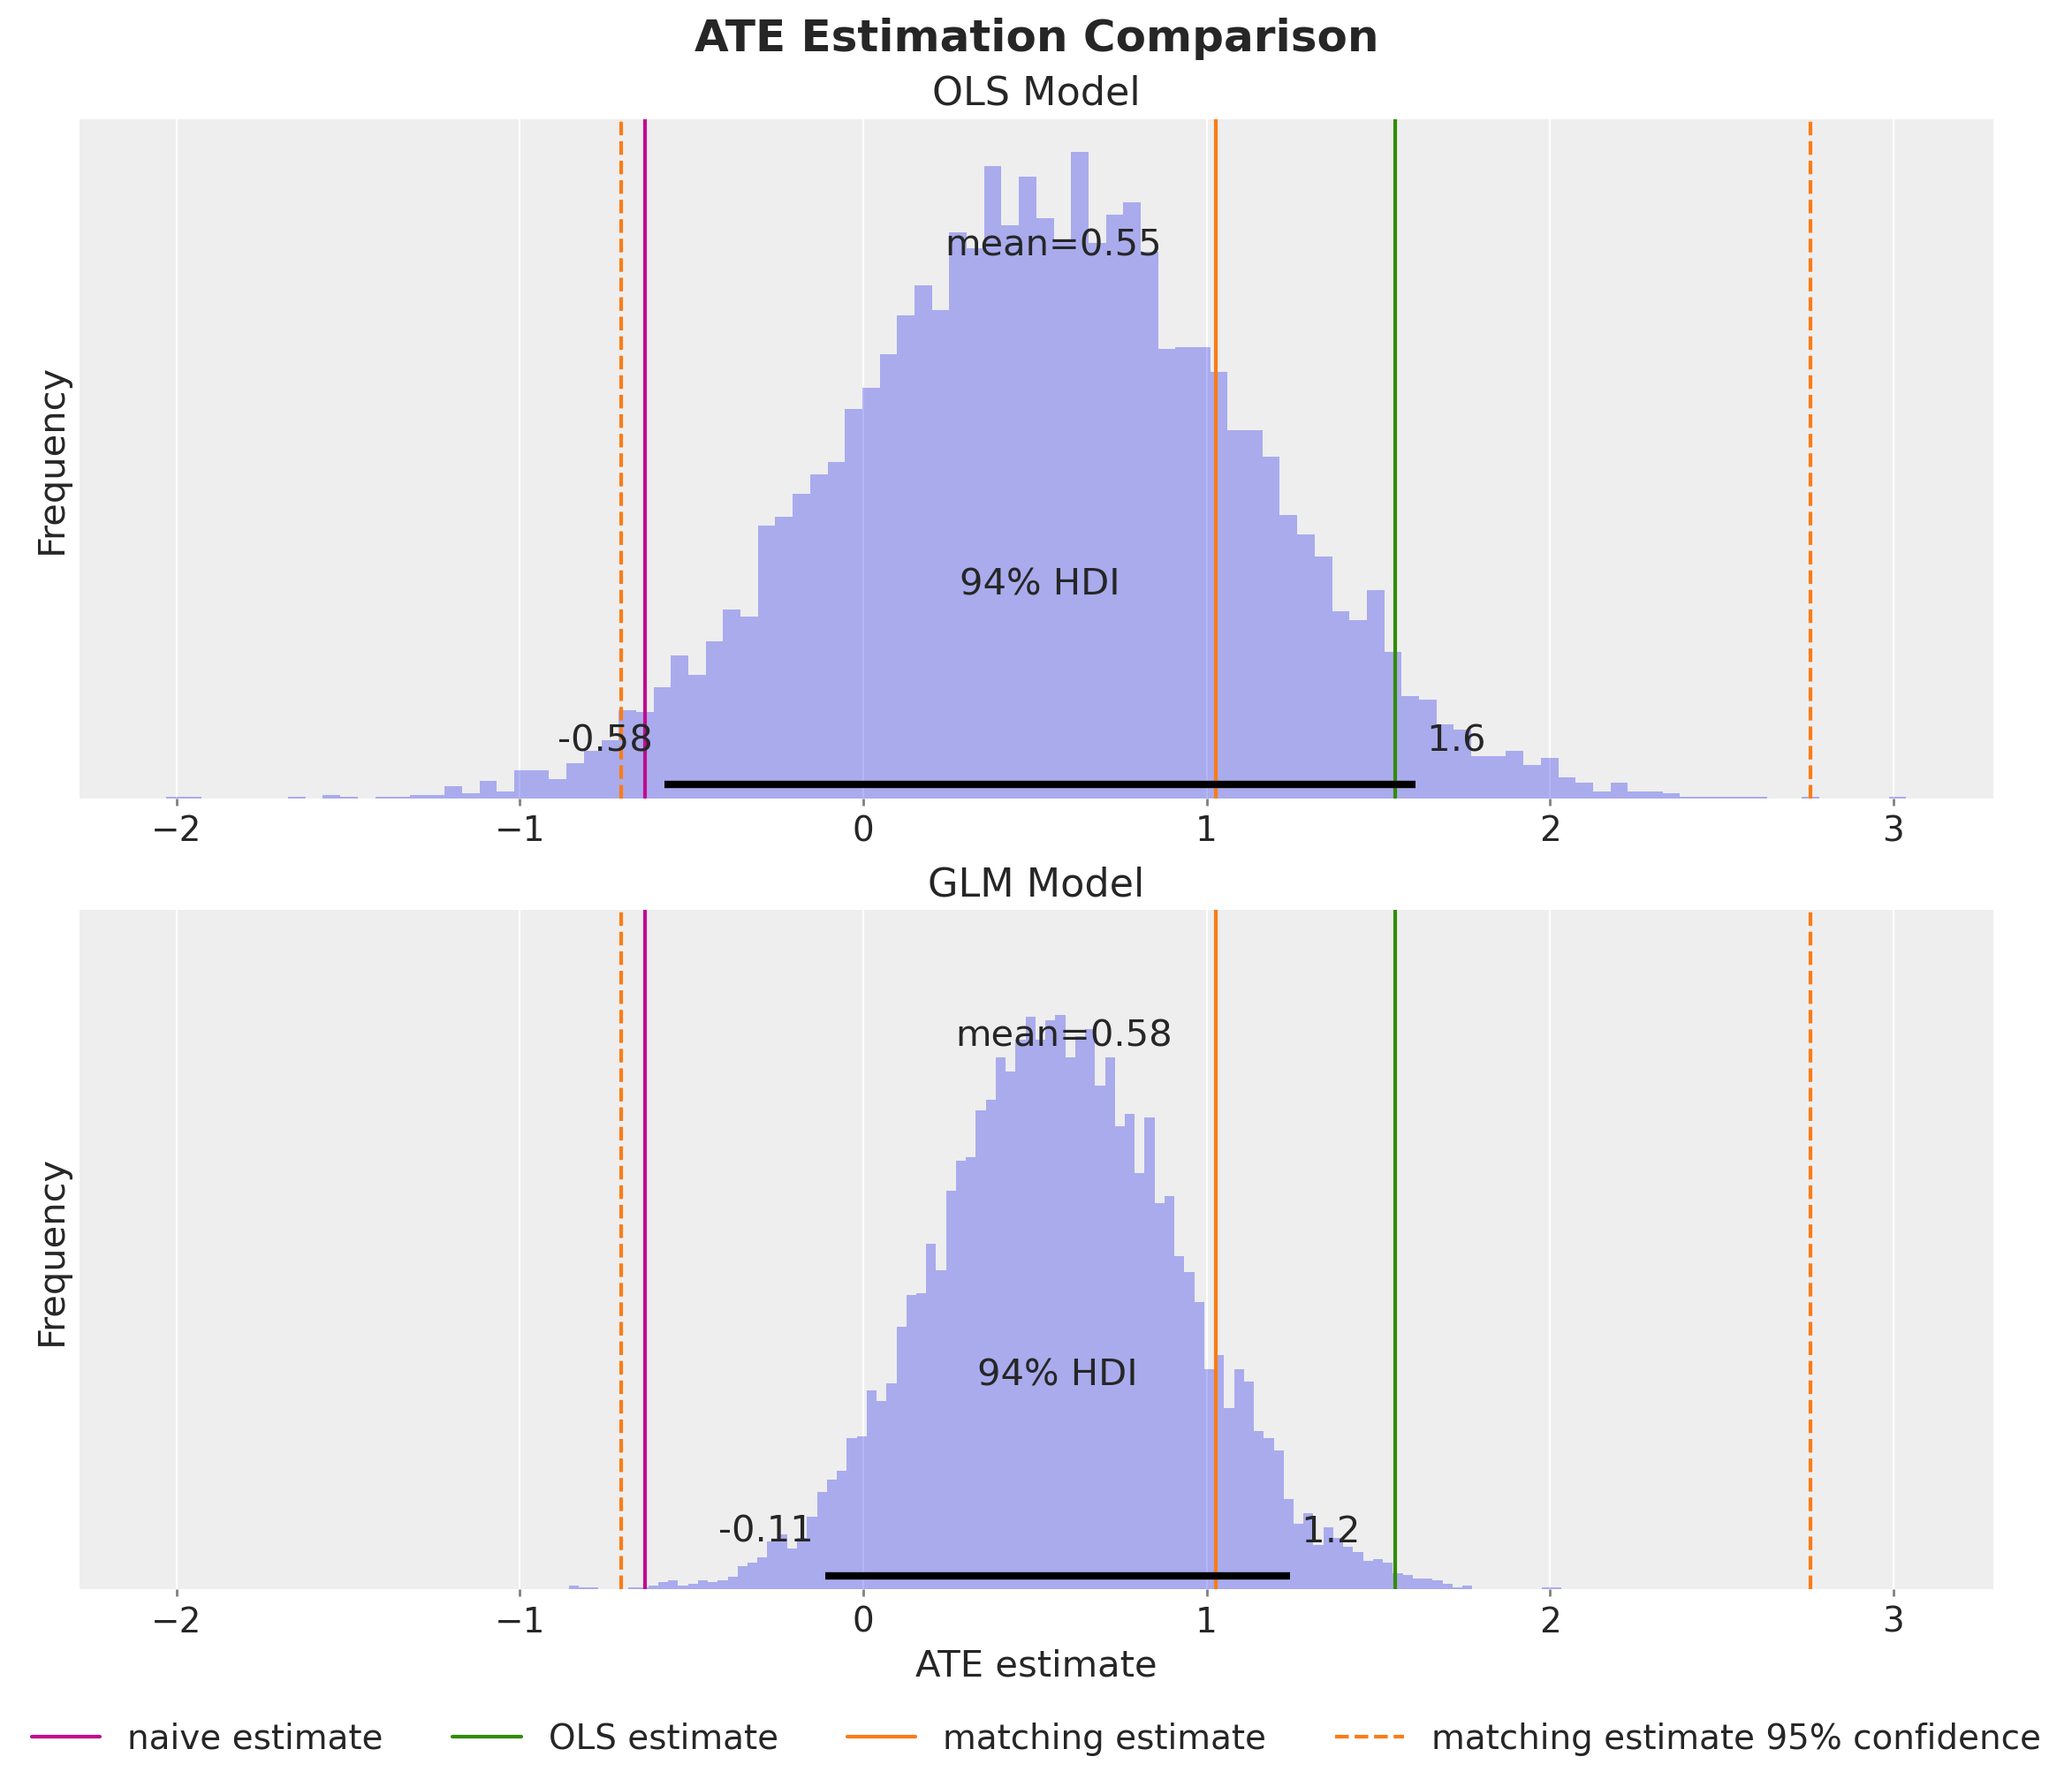

In [36]:
glm_expected_do_1 = glm_do_1_idata["posterior_predictive"]["mu_earnings"]

glm_expected_do_0 = glm_do_0_idata["posterior_predictive"]["mu_earnings"]

glm_ate = (glm_expected_do_1 - glm_expected_do_0).mean(dim="obs_idx").rename("ate")


fig, ax = plt.subplots(
    nrows=2,
    figsize=(12, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)

ax[0].axvline(naive_prediction, color="C3", label="naive estimate")
ax[0].axvline(blog_prediction_ols, color="C2", label="OLS estimate")
ax[0].axvline(blog_prediction_matching, color="C1", label="matching estimate")
ax[0].axvline(
    blog_prediction_matching_ci95[0],
    color="C1",
    linestyle="dashed",
    label="matching estimate 95% confidence",
)
ax[0].axvline(
    blog_prediction_matching_ci95[1],
    color="C1",
    linestyle="dashed",
)
az.plot_posterior(ate, kind="hist", bins=100, color="C0", ax=ax[0])
ax[0].set(title="OLS Model", ylabel="Frequency")


ax[1].axvline(naive_prediction, color="C3", label="naive estimate")
ax[1].axvline(blog_prediction_ols, color="C2", label="OLS estimate")
ax[1].axvline(blog_prediction_matching, color="C1", label="matching estimate")
ax[1].axvline(
    blog_prediction_matching_ci95[0],
    color="C1",
    linestyle="dashed",
    label="matching estimate 95% confidence",
)
ax[1].axvline(
    blog_prediction_matching_ci95[1],
    color="C1",
    linestyle="dashed",
)
az.plot_posterior(glm_ate, kind="hist", bins=100, color="C0", ax=ax[1])
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
ax[1].set(title="GLM Model", xlabel="ATE estimate", ylabel="Frequency")
fig.suptitle("ATE Estimation Comparison", fontsize=18, fontweight="bold");

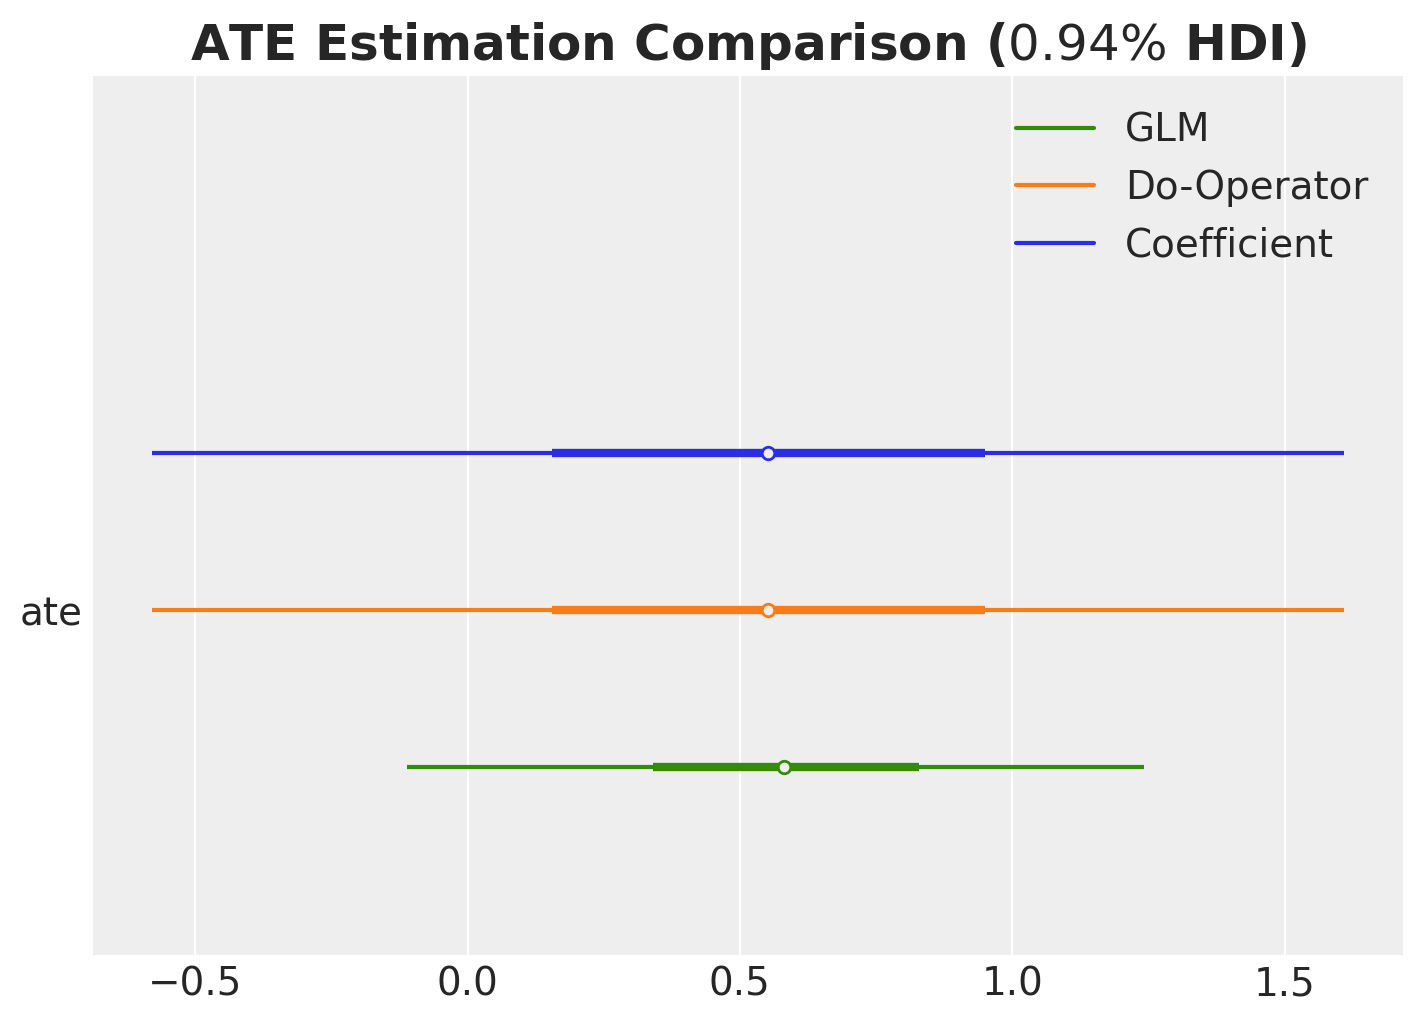

In [37]:
ax, *_ = az.plot_forest(
    data=[
        idata["posterior"].rename({"beta_treat_earnings": "ate"})["ate"],
        ate,
        glm_ate,
    ],
    model_names=["Coefficient", "Do-Operator", "GLM"],
    var_names=["ate"],
    combined=True,
    hdi_prob=0.94,
    figsize=(7, 5),
)
ax.set_title(
    r"ATE Estimation Comparison ($0.94\%$ HDI)", fontsize=18, fontweight="bold"
);

In [38]:
%reload_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Nov 15 2025

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.7.0

numpyro   : 0.19.0
jaxtyping : 0.3.3
sklearn   : 1.6.1
graphviz  : 0.21
arviz     : 0.22.0
numpy     : 2.3.4
jax       : 0.8.0
seaborn   : 0.13.2
pandas    : 2.3.3
matplotlib: 3.10.7

Watermark: 2.5.0

